# Data Processing

In [1]:
import pickle
from pathlib import Path
from typing import List, Iterator

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import IterableDataset, DataLoader
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, GraphUNet
from tqdm import tqdm
import matplotlib.pyplot as plt

class IterativeRolloutDataset(IterableDataset):
    """
    Yields consecutive *shifted* sequences of timesteps:
      [ (Data[t].x, Data[t+1].y), (Data[t+1].x, Data[t+2].y), ..., (Data[t+seq_len-1].x, Data[t+seq_len].y) ]
    for each simulation.
    """
    def __init__(self,
                 directory: Path,
                 hydrograph_ids: List[str],
                 seq_len: int,
                 num_static_feats: int,
                 num_dynamic_feats: int):
        """
        Args:
            directory (Path): Directory containing your pickled simulation files.
            hydrograph_ids (List[str]): List of simulation IDs (file stems).
            seq_len (int): Number of consecutive steps in each returned window.
                           NOTE: Because we shift y by +1, we actually need seq_len+1 timesteps.
            num_static_feats (int): Number of static features in data.x.
            num_dynamic_feats (int): Number of dynamic features in data.x.
        """
        super().__init__()
        self.directory = directory
        self.hydrograph_ids = hydrograph_ids
        self.seq_len = seq_len
        self.num_static_feats = num_static_feats
        self.num_dynamic_feats = num_dynamic_feats

    def __iter__(self) -> Iterator[List[Data]]:
        for hid in self.hydrograph_ids:
            pickle_file = self.directory / f"{hid}.pkl"
            try:
                with open(pickle_file, 'rb') as file:
                    sim = pickle.load(file)
                    if not isinstance(sim, list):
                        print(f"Unexpected data format in {pickle_file}. Skipping.")
                        continue
                    T = len(sim)
                    max_start = T - self.seq_len
                    if max_start < 1:
                        continue
                    for start_idx in range(max_start):
                        window = []
                        for offset in range(self.seq_len):
                            t = start_idx + offset
                            data_t = sim[t].clone()
                            # Partition x into static and dynamic parts using parameterized indices
                            static_feats = data_t.x[:, :self.num_static_feats]
                            dynamic_feats = data_t.x[:, self.num_static_feats:self.num_static_feats + self.num_dynamic_feats]
                            data_t.x = torch.cat([static_feats, dynamic_feats], dim=1)
                            # Overwrite y with next timestep's ground truth
                            data_tplus1 = sim[t+1]
                            data_t.y = data_tplus1.y.clone()
                            window.append(data_t)
                        yield window
            except FileNotFoundError:
                print(f"Pickle file not found: {pickle_file}")
            except Exception as e:
                print(f"Error loading {pickle_file}: {e}")

def get_hydrograph_ids(directory: Path) -> List[str]:
    return [file.stem for file in directory.glob("*.pkl")]


/home/jtb3sud/.local/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/jtb3sud/.local/lib/python3.10/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


# Model

In [2]:
class FeatureExtractorGNN(nn.Module):
    """
    GraphUNet-based feature extractor for each node with attention.
    """
    def __init__(self, in_channels=9, hidden_channels=64, out_channels=32, depth=3, pool_ratios=0.5, heads=4, concat=True, dropout=0.6):
        super(FeatureExtractorGNN, self).__init__()
        self.unet = GraphUNet(
            in_channels=in_channels,
            hidden_channels=hidden_channels,
            out_channels=out_channels,
            depth=depth,
            pool_ratios=pool_ratios,
            act=F.relu
        )
        self.attention1 = GATConv(out_channels, out_channels, heads=heads, concat=concat, dropout=dropout)
        self.attention2 = GATConv(out_channels * heads if concat else out_channels, out_channels, heads=1, concat=False, dropout=dropout)
        self.residual = nn.Linear(out_channels, out_channels)

    def forward(self, x, edge_index):
        residual = self.unet(x, edge_index)
        x = F.elu(self.attention1(residual, edge_index))
        x = self.attention2(x, edge_index)
        x += residual
        return x

class DerivativeGNN(nn.Module):
    """
    GNN that approximates Fdot = dF/dt using Graph Attention.
    """
    def __init__(self, in_channels, out_channels=64, heads=4, concat=True, dropout=0.6):
        super(DerivativeGNN, self).__init__()
        self.gat1 = GATConv(in_channels, 64, heads=heads, concat=concat, dropout=dropout)
        self.gat2 = GATConv(64 * heads if concat else 64, out_channels, heads=1, concat=False, dropout=dropout)

    def forward(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))
        x = self.gat2(x, edge_index)
        return x

class IntegralGNN(nn.Module):
    """
    GNN that learns the integral operator: ΔF = ∫ Fdot dt using Graph Attention.
    """
    def __init__(self, in_channels=64, out_channels=4, heads=4, concat=True, dropout=0.6):
        super(IntegralGNN, self).__init__()
        self.gat1 = GATConv(in_channels, 64, heads=heads, concat=concat, dropout=dropout)
        self.gat2 = GATConv(64 * heads if concat else 64, out_channels, heads=1, concat=False, dropout=dropout)

    def forward(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))
        x = self.gat2(x, edge_index)
        return x

# Recurrent

In [3]:
class GPARCRecurrent(nn.Module):
    """
    Recurrent GPARC that processes a sequence of Data objects.
    The feature extractor is now integrated so that its parameters are updated during training.
    """
    def __init__(self, feature_extractor, derivative_solver, integral_solver, 
                 num_static_feats=9, num_dynamic_feats=4):
        super().__init__()
        self.feature_extractor = feature_extractor  # Integrated learnable feature extractor
        self.derivative_solver = derivative_solver
        self.integral_solver = integral_solver
        self.num_static_feats = num_static_feats
        self.num_dynamic_feats = num_dynamic_feats

    def forward(self, data_list):
        predictions = []
        F_prev = None
        # Compute the learned static feature map from the first timestep’s static features.
        static_feats_0 = data_list[0].x[:, :self.num_static_feats]
        edge_index_0 = data_list[0].edge_index
        learned_static_feature_map = self.feature_extractor(static_feats_0, edge_index_0)
        
        for data in data_list:
            x = data.x
            edge_index = data.edge_index
            # Extract dynamic features (assumed to be after the first num_static_feats columns)
            dynamic_feats_t = x[:, self.num_static_feats:self.num_static_feats + self.num_dynamic_feats]
            F_prev_used = dynamic_feats_t if F_prev is None else F_prev
            
            # Concatenate the dynamic state with the learned static feature map
            Fdot_input = torch.cat([F_prev_used, learned_static_feature_map], dim=-1)
            Fdot = self.derivative_solver(Fdot_input, edge_index)
            Fint = self.integral_solver(Fdot, edge_index)
            F_pred = F_prev_used + Fint
            predictions.append(F_pred)
            F_prev = F_pred
        return predictions

# Make Dataloader

In [4]:
# Define paths and parameters
base_directory = Path("/scratch/jtb3sud/combined/")
train_dir = base_directory / "train/normalized"       # Replace with actual train data path
val_dir   = base_directory / "val/normalized"         # Replace with actual validation data path
test_dir  = base_directory / "test/normalized"  # Replace with actual test data path

# Get hydrograph IDs
train_ids = get_hydrograph_ids(train_dir)
val_ids   = get_hydrograph_ids(val_dir)
test_ids  = get_hydrograph_ids(test_dir)
print(f"[Data] #Train IDs = {len(train_ids)}, #Val IDs = {len(val_ids)}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1) Initialize Dataset
seq_len = 1
num_static_feats=9
num_dynamic_feats=4

train_dataset = IterativeRolloutDataset(
    directory=train_dir,
    hydrograph_ids=train_ids,
    seq_len=seq_len,
    num_static_feats=num_static_feats,
    num_dynamic_feats=num_dynamic_feats
)

# 2) Wrap in DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=None,  # Because it's an IterableDataset of variable sequence lengths
    shuffle=False,
    num_workers=0
)

val_dataset = IterativeRolloutDataset(
    directory=val_dir,
    hydrograph_ids=val_ids,
    seq_len=seq_len,
    num_static_feats=num_static_feats,
    num_dynamic_feats=num_dynamic_feats
)

# 2) Wrap in DataLoader
val_loader = DataLoader(
    val_dataset,
    batch_size=None,  # Because it's an IterableDataset of variable sequence lengths
    shuffle=False,
    num_workers=0
)

test_dataset = IterativeRolloutDataset(
    directory=test_dir,
    hydrograph_ids=test_ids,
    seq_len=seq_len,
    num_static_feats=num_static_feats,
    num_dynamic_feats=num_dynamic_feats
)

# 2) Wrap in DataLoader
test_loader = DataLoader(
    test_dataset,
    batch_size=None,  # Because it's an IterableDataset of variable sequence lengths
    shuffle=False,
    num_workers=0
)
print("SEQUENCE LENGTH", seq_len)

[Data] #Train IDs = 0, #Val IDs = 0
Using device: cuda
SEQUENCE LENGTH 1


In [5]:
# Instantiate submodules as before.
feature_extractor = FeatureExtractorGNN(
    in_channels=num_static_feats,
    hidden_channels=64,
    out_channels=128,
    depth=2,
    pool_ratios=0.1,
    heads=4,
    concat=True,
    dropout=0.2
).to(device)

derivative_solver = DerivativeGNN(
    in_channels=128 + num_dynamic_feats,  # 128 from feature extractor + dynamic features
    out_channels=4,
    heads=4,
    concat=True,
    dropout=0.2
).to(device)

integral_solver = IntegralGNN(
    in_channels=4,
    out_channels=num_dynamic_feats,
    heads=4,
    concat=True,
    dropout=0.2
).to(device)

# Now integrate them in the recurrent model:
model = GPARCRecurrent(
    feature_extractor=feature_extractor,
    derivative_solver=derivative_solver,
    integral_solver=integral_solver,
    num_static_feats=num_static_feats,
    num_dynamic_feats=num_dynamic_feats
).to(device)


# Load Model

In [6]:
def load_model(model, model_path, device="cpu"):
    if Path(model_path).exists():
        print(f"Loading checkpoint from {model_path}")
        checkpoint = torch.load(model_path, map_location=device)
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            print("Loaded checkpoint for the integrated model.")
        else:
            model.load_state_dict(checkpoint)
            print("Loaded model checkpoint (only model).")
    else:
        print("No checkpoint provided. Training from scratch.")
    model.to(device)
    model.eval()  # Set to evaluation mode
    return model

# Example usage:
model_path = "/home/jtb3sud/G-PARC/weights/new_river/modelseq20_ep250.pth"  # Change this to your actual model path
model = load_model(model, model_path, device)


Loading checkpoint from /home/jtb3sud/G-PARC/weights/new_river/modelseq20_ep250.pth
Loaded checkpoint for the integrated model.


# Denormalize

# old way lost data

# Old main

# New Main

In [8]:
def count_parameters(model: torch.nn.Module):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Fixed parameters: {total_params - trainable_params:,}")

# Usage
count_parameters(model)


Total parameters: 209,496
Trainable parameters: 209,496
Fixed parameters: 0


In [9]:
def print_model_layers(model: torch.nn.Module):
    """
    Prints each immediate child module name and type,
    and then the total count of those child modules.
    """
    children = list(model.named_children())
    print(f"Model has {len(children)} top-level submodules:")
    for name, layer in children:
        print(f"  • {name}: {type(layer).__name__}")
    print()

    # If you want to count *all* modules (including nested):
    all_modules = list(model.modules())
    print(f"Total modules (including parent & nested): {len(all_modules)}")

# Usage
print_model_layers(model)


Model has 3 top-level submodules:
  • feature_extractor: FeatureExtractorGNN
  • derivative_solver: DerivativeGNN
  • integral_solver: IntegralGNN

Total modules (including parent & nested): 50


# Viz

In [10]:
import pickle
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import math
import h5py

# ---------------------------
# Global Configuration
# ---------------------------
FEATURE_MAPPING = {
    0: "Water Depth",
    1: "Volume",
    2: "Velocity X",
    3: "Velocity Y"
}

# Path to your saved denormalization extrema
EXTREMA_PATH = Path("/home/jtb3sud/G-PARC/demos/new_river/global_y_extrema_test.pth")

# Load global denormalization extrema once
tmp = torch.load(EXTREMA_PATH)
y_mins, y_maxs = tmp['y_min'], tmp['y_max']

# ---------------------------
# Helper Function Definitions
# ---------------------------

def load_static_mesh(hdf_path: Path, facepts_ds: str, cells_ds: str):
    """Load mesh vertices and cell-to-vertex connectivity from HDF5."""
    with h5py.File(hdf_path, "r") as f:
        facepts = f[facepts_ds][:]
        cells   = f[cells_ds][:]
    print(f"[mesh] loaded {len(facepts)} verts, {len(cells)} cells")
    return facepts, cells


def get_important_mask(graphs, num_static_feats: int, pred_idx: int, threshold: float = 0.0):
    """
    Returns a boolean mask of graph nodes (one per mesh cell) that ever exceed
    the threshold in denormalized physical units for feature pred_idx.
    """
    n = graphs[0].x.size(0)
    mask = torch.zeros(n, dtype=torch.bool)
    y_min, y_max = y_mins[pred_idx], y_maxs[pred_idx]
    for i in range(n):
        # t=0
        norm0 = graphs[0].x[i, num_static_feats + pred_idx]
        val0  = norm0 * (y_max - y_min) + y_min
        if val0.item() > threshold:
            mask[i] = True
            continue
        # later timesteps
        for g in graphs[1:]:
            normv = g.y[i, pred_idx] if hasattr(g, 'y') else g.x[i, num_static_feats + pred_idx]
            val   = normv * (y_max - y_min) + y_min
            if val.item() > threshold:
                mask[i] = True
                break
    return mask


def visualize_important_nodes_for_simulation(
    file_path: Path,
    num_static_feats: int,
    pred_idx: int,
    mesh_hdf_path: Path,
    facepts_ds: str,
    cells_ds: str,
    threshold: float = 0.0,
    save_path: Path = None
):
    """
    Plot the mesh with cells colored red if the corresponding graph node's
    denormalized value at t=0 (feature pred_idx) exceeds threshold.
    """
    # Load simulation
    graphs = pickle.load(open(file_path, 'rb'))
    # Compute mask of important nodes (one per mesh cell)
    mask = get_important_mask(graphs, num_static_feats, pred_idx, threshold).numpy()
    # Load mesh
    facepts, cells = load_static_mesh(mesh_hdf_path, facepts_ds, cells_ds)

    polys, cols = [], []
    for cell_idx, vert_ids in enumerate(cells):
        # get vertex coordinates
        valid = (vert_ids >= 0) & (vert_ids < len(facepts))
        pts = facepts[vert_ids[valid].astype(int)]
        if len(pts) < 3:
            continue
        polys.append(pts)
        cols.append(1 if mask[cell_idx] else 0)
    cols = np.array(cols)

    cmap = ListedColormap(['#e0e0e0', '#7eaedb'])
    pc = PolyCollection(
        polys,
        facecolors=cmap(cols),
        edgecolors='k',
        linewidths=0.2
    )

    fig, ax = plt.subplots(figsize=(8,6))
    ax.add_collection(pc)
    ax.autoscale_view()
    ax.axis('off')
    ax.set_title(f"Important Nodes (> {threshold:.2f}) for {FEATURE_MAPPING[pred_idx]}", fontsize=14)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()




def evaluate_avg_values(graphs, feature_extractor, model, device, num_static_feats, pred_idx):
    """
    Runs an autoregressive rollout for one sim and returns lists of
    average denormalized prediction and GT over important nodes per timestep.
    """
    mask = get_important_mask(graphs, num_static_feats, pred_idx, threshold=0.0).to(device)
    y_min, y_max = y_mins[pred_idx], y_maxs[pred_idx]

    current = graphs[0].clone().to(device)
    avg_pred, avg_gt = [], []

    for t in range(len(graphs) - 1):
        with torch.no_grad():
            F_pred = model([current])[0]                          # shape [n_nodes, n_dyn_feats]
        # extract normalized arrays
        pred_norm = F_pred[:, pred_idx]
        gt_graph  = graphs[t+1]
        gt_norm   = (gt_graph.y[:, pred_idx] if hasattr(gt_graph, 'y')
                     else gt_graph.x[:, num_static_feats + pred_idx]).to(device)

        # denormalize
        pred_phys = pred_norm * (y_max - y_min) + y_min
        gt_phys   = gt_norm  * (y_max - y_min) + y_min

        # average over important nodes
        avg_pred.append(pred_phys[mask].mean().item())
        avg_gt.append  (gt_phys[mask].mean().item())

        # update for next step
        current = current.clone()
        x_new   = current.x.clone()
        x_new[:, num_static_feats:] = F_pred
        current.x = x_new

    return avg_pred, avg_gt


def aggregate_avg_values(simulation_files, feature_extractor, model, device,
                         num_static_feats, pred_idx, threshold=0.0):
    """
    Aggregates average curves (important nodes) across sims and plots mean±1σ.
    """
    # determine min rollout length
    min_len = min(
        (len(pickle.load(open(f, 'rb'))) - 1)
        for f in simulation_files
    )
    print(f"Using rollout length = {min_len}")
    all_pred, all_gt = [], []
    for fpath in simulation_files:
        graphs = pickle.load(open(fpath, 'rb'))
        pred, gt = evaluate_avg_values(graphs, feature_extractor,
                                       model, device,
                                       num_static_feats, pred_idx)
        all_pred.append(pred[:min_len])
        all_gt.append(  gt[:min_len])

    all_pred = np.array(all_pred)
    all_gt   = np.array(all_gt)
    t = np.arange(1, min_len + 1)
    pm, ps = all_pred.mean(0), all_pred.std(0)
    gm, gs = all_gt.mean(0),   all_gt.std(0)
    name = FEATURE_MAPPING[pred_idx]

    plt.figure(figsize=(8,6))
    plt.plot(t, pm, marker='o', label="Predicted")
    plt.fill_between(t, pm-ps, pm+ps, alpha=0.3)
    plt.plot(t, gm, marker='s', label="Ground Truth")
    plt.fill_between(t, gm-gs, gm+gs, alpha=0.3)
    plt.title(f"{name} (important nodes)")
    plt.xlabel("Timestep")
    plt.ylabel("Physical Value")
    plt.legend()
    plt.grid(True)
    plt.show()


def aggregate_avg_values_variable_return(simulation_files, feature_extractor, model, device,
                                         num_static_feats, pred_idx, threshold=0.0):
    """
    Same as above, but returns (timesteps, pm, ps, gm, gs, feature_name)
    """
    all_pred, all_gt, lengths = [], [], []
    for fpath in simulation_files:
        graphs = pickle.load(open(fpath, 'rb'))
        pred, gt = evaluate_avg_values(graphs, feature_extractor,
                                       model, device,
                                       num_static_feats, pred_idx)
        all_pred.append(pred)
        all_gt.append(  gt)
        lengths.append(len(pred))
    max_len = max(lengths)
    t = np.arange(1, max_len + 1)
    pm, ps, gm, gs = [], [], [], []
    for i in range(max_len):
        vals_p = [a[i] for a in all_pred if len(a) > i]
        vals_g = [a[i] for a in all_gt   if len(a) > i]
        pm.append(np.mean(vals_p)); ps.append(np.std(vals_p))
        gm.append(np.mean(vals_g)); gs.append(np.std(vals_g))
    return t, np.array(pm), np.array(ps), np.array(gm), np.array(gs), FEATURE_MAPPING[pred_idx]


def plot_segments(timesteps, pm, ps, gm, gs, feature_name, segments):
    """
    Plots sub‐ranges of the average curves, given segment boundaries.
    """
    for (s,e) in segments:
        idx = np.where((timesteps>=s)&(timesteps<e))[0]
        if len(idx)==0: continue
        plt.figure(figsize=(8,6))
        plt.plot(timesteps[idx], pm[idx], marker='o', label="Pred")
        plt.fill_between(timesteps[idx], pm[idx]-ps[idx], pm[idx]+ps[idx], alpha=0.3)
        plt.plot(timesteps[idx], gm[idx], marker='s', label="GT")
        plt.fill_between(timesteps[idx], gm[idx]-gs[idx], gm[idx]+gs[idx], alpha=0.3)
        plt.title(f"{feature_name} (timesteps {s}–{e})")
        plt.xlabel("Timestep"); plt.ylabel("Value")
        plt.legend(); plt.grid(True)
        plt.show()


def determine_time_segments(simulation_files, min_segment_length=10, drop_threshold=0.8):
    """
    Splits the rollout into time segments based on how many sims remain.
    """
    lengths = np.array([len(pickle.load(open(f,'rb')))-1 for f in simulation_files])
    max_len = lengths.max()
    counts  = np.array([np.sum(lengths>=t) for t in range(1, max_len+1)])
    segments, start = [], 1
    for t in range(1, max_len):
        if counts[t] < counts[t-1] * drop_threshold:
            if (t+1 - start) >= min_segment_length:
                segments.append((start, t+1))
                start = t+1
    if (max_len+1 - start) >= min_segment_length:
        segments.append((start, max_len+1))
    return segments, counts, lengths


def evaluate_correlation(graphs, feature_extractor, model, device, num_static_feats, pred_idx):
    """
    Rollout one sim, collect denormalized pred vs gt for every node & timestep.
    """
    y_min, y_max = y_mins[pred_idx], y_maxs[pred_idx]
    current = graphs[0].clone().to(device)
    preds, gts = [], []
    for t in range(len(graphs)-1):
        with torch.no_grad():
            F_pred = model([current])[0]
        # normalized
        pnorm = F_pred[:, pred_idx].cpu().numpy()
        gnorm = ((graphs[t+1].y[:,pred_idx] if hasattr(graphs[t+1],'y')
                  else graphs[t+1].x[:, num_static_feats+pred_idx])
                 .cpu().numpy())
        # denormalize
        p = pnorm * (y_max-y_min) + y_min
        g = gnorm * (y_max-y_min) + y_min
        preds.extend(p.tolist())
        gts.extend(g.tolist())
        # update
        current = current.clone()
        x_new = current.x.clone()
        x_new[:, num_static_feats:] = F_pred
        current.x = x_new
    return preds, gts


def compute_correlation_metric(simulation_files, feature_extractor, model, device, num_static_feats, pred_idx):
    """
    Pearson r over all sims.
    """
    all_p, all_g = [], []
    for fpath in simulation_files:
        graphs = pickle.load(open(fpath, 'rb'))
        p, g = evaluate_correlation(graphs, feature_extractor,
                                    model, device,
                                    num_static_feats, pred_idx)
        all_p.extend(p); all_g.extend(g)
    corr = np.corrcoef(all_g, all_p)[0,1]
    return corr


def correlation_plot(simulation_files, feature_extractor, model, device, num_static_feats, pred_idx):
    """
    Scatter plot of GT vs Pred with Pearson r.
    """
    p, g = [], []
    for f in simulation_files:
        graphs = pickle.load(open(f,'rb'))
        pp, gg = evaluate_correlation(graphs, feature_extractor,
                                      model, device,
                                      num_static_feats, pred_idx)
        p.extend(pp); g.extend(gg)
    corr = np.corrcoef(g, p)[0,1]
    print(f"Pearson r = {corr:.3f}")
    plt.figure(figsize=(8,6))
    plt.scatter(g, p, alpha=0.3)
    m, M = min(min(g), min(p)), max(max(g), max(p))
    plt.plot([m,M],[m,M],'r--')
    plt.xlabel("Ground Truth"); plt.ylabel("Prediction")
    plt.title(f"{FEATURE_MAPPING[pred_idx]} Correlation")
    plt.grid(True)
    plt.show()


def evaluate_nonimportant_changes(graphs, feature_extractor, model, device, num_static_feats, pred_idx):
    """
    Rollout one sim, compute avg absolute change from t0 for non-important nodes.
    """
    mask_imp = get_important_mask(graphs, num_static_feats, pred_idx, threshold=0.0)
    mask_non = (~mask_imp).to(device)
    y_min, y_max = y_mins[pred_idx], y_maxs[pred_idx]
    init_norm = graphs[0].x[:, num_static_feats+pred_idx].to(device)
    init_phys = init_norm * (y_max-y_min) + y_min

    current = graphs[0].clone().to(device)
    pred_changes, gt_changes = [], []
    for t in range(len(graphs)-1):
        with torch.no_grad():
            F_pred = model([current])[0]
        pnorm = F_pred[:, pred_idx]
        gnorm = (graphs[t+1].y[:,pred_idx] if hasattr(graphs[t+1],'y')
                 else graphs[t+1].x[:,num_static_feats+pred_idx]).to(device)
        p_phys = pnorm * (y_max-y_min) + y_min
        g_phys = gnorm * (y_max-y_min) + y_min
        pred_changes.append(torch.mean(torch.abs(p_phys - init_phys)[mask_non]).item())
        gt_changes.append(  torch.mean(torch.abs(g_phys - init_phys)[mask_non]).item())
        # update
        current = current.clone()
        x_new = current.x.clone()
        x_new[:, num_static_feats:] = F_pred
        current.x = x_new

    return pred_changes, gt_changes


def aggregate_nonimportant_changes(simulation_files, feature_extractor, model, device,
                                   num_static_feats, pred_idx, threshold=0.0):
    """
    Aggregates avg absolute changes for non-important nodes across sims.
    """
    min_len = min(len(pickle.load(open(f,'rb'))) - 1 for f in simulation_files)
    print(f"Using rollout length = {min_len}")
    all_p, all_g = [], []
    for f in simulation_files:
        graphs = pickle.load(open(f,'rb'))
        pc, gc = evaluate_nonimportant_changes(graphs, feature_extractor,
                                               model, device,
                                               num_static_feats, pred_idx)
        all_p.append(pc[:min_len])
        all_g.append(gc[:min_len])

    all_p = np.array(all_p); all_g = np.array(all_g)
    t = np.arange(1, min_len+1)
    pm, ps = all_p.mean(0), all_p.std(0)
    gm, gs = all_g.mean(0), all_g.std(0)
    name = FEATURE_MAPPING[pred_idx]

    plt.figure(figsize=(8,6))
    plt.plot(t, pm, marker='o', label="Predicted change")
    plt.fill_between(t, pm-ps, pm+ps, alpha=0.3)
    plt.plot(t, gm, marker='s', label="GT change")
    plt.fill_between(t, gm-gs, gm+gs, alpha=0.3)
    plt.title(f"{name} | Non-important nodes")
    plt.xlabel("Timestep"); plt.ylabel("Absolute Change")
    plt.legend(); plt.grid(True)
    plt.show()


def plot_segments_grid(timesteps, pm, ps, gm, gs, feature_name, segments,
                       output_filename="segments_plot.png"):
    """
    Plots multiple segment subplots in a grid, sharing y‐axis, saved to file.
    """
    nseg = len(segments)
    if nseg == 0:
        print("No segments to plot.")
        return
    ncols = 2
    nrows = math.ceil(nseg / ncols)
    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(ncols*8, nrows*6),
                             squeeze=False, sharey=True)
    # global y‐limits
    y_min_gl = min((pm-ps).min(), (gm-gs).min())
    y_max_gl = max((pm+ps).max(), (gm+gs).max())

    for idx, (s,e) in enumerate(segments):
        r, c = divmod(idx, ncols)
        ax = axes[r][c]
        ix = np.where((timesteps>=s)&(timesteps<e))[0]
        if ix.size == 0:
            ax.set_title(f"{feature_name} ({s}-{e}): no data")
            continue
        ax.plot(timesteps[ix], pm[ix], marker='o', label="Pred")
        ax.fill_between(timesteps[ix], pm[ix]-ps[ix], pm[ix]+ps[ix], alpha=0.3)
        ax.plot(timesteps[ix], gm[ix], marker='s', label="GT")
        ax.fill_between(timesteps[ix], gm[ix]-gs[ix], gm[ix]+gs[ix], alpha=0.3)
        ax.set_title(f"{feature_name}\n{s}→{e}", fontsize=18)
        ax.set_xlabel("Timestep", fontsize=16)
        ax.set_ylabel("Value", fontsize=16)
        ax.legend(fontsize=14)
        ax.grid(True)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        ax.set_ylim(y_min_gl, y_max_gl)
        ax.tick_params(labelsize=14)

    # remove empty axes
    for i in range(idx+1, nrows*ncols):
        r, c = divmod(i, ncols)
        fig.delaxes(axes[r][c])

    plt.tight_layout()
    fig.savefig(output_filename, bbox_inches='tight', dpi=300)
    print(f"Saved segments grid to {output_filename}")
    plt.show()


Found 150 simulation files.
[mesh] loaded 2795 verts, 2666 cells


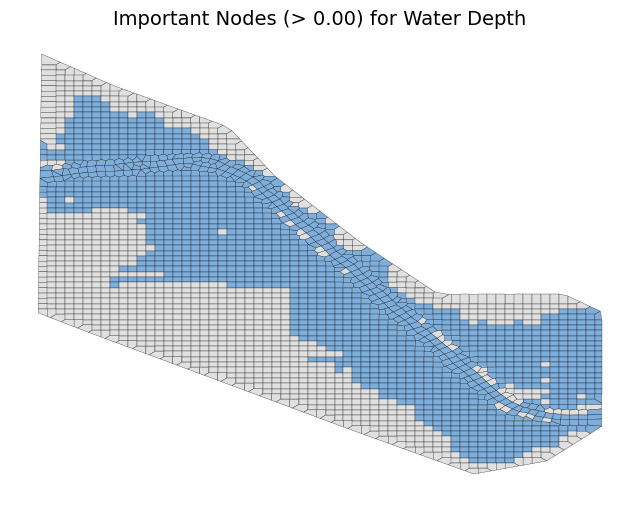

[mesh] loaded 5734 verts, 5081 cells


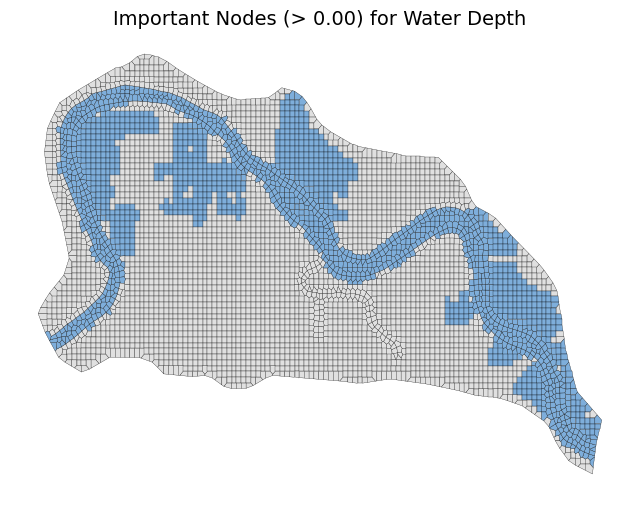

In [11]:
# Update these paths as needed
import pickle
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Where your normalized simulation pickles live
ground_truth_folder = Path("/scratch/jtb3sud/hecras/combined_normalized/test")
simulation_files    = list(ground_truth_folder.glob("*.pkl"))
print(f"Found {len(simulation_files)} simulation files.")

# Parameters (adjust as needed)
pred_idx         = 0   # dynamic variable index (0…num_dynamic_feats-1)
threshold        = 0.0 # physical‐unit threshold for importance
num_static_feats = 9   # as before

# Mesh definitions for Iowa River
mesh_hdf_iowa = Path("/home/jtb3sud/G-PARC/demos/mesh_cells/Flood_GNN.p01.hdf")
facepts_iowa  = "Geometry/2D Flow Areas/Flow Area/FacePoints Coordinate"
cells_iowa    = "Geometry/2D Flow Areas/Flow Area/Cells FacePoint Indexes"

# Mesh definitions for White River
mesh_hdf_white = Path("/home/jtb3sud/G-PARC/demos/mesh_cells/Muncie2D_SI.p02.hdf")
facepts_white  = "Geometry/2D Flow Areas/Perimeter 1/FacePoints Coordinate"
cells_white    = "Geometry/2D Flow Areas/Perimeter 1/Cells FacePoint Indexes"

# (1) Visualize important nodes on the Iowa River mesh
if simulation_files:
    visualize_important_nodes_for_simulation(
        file_path      = simulation_files[12],
        num_static_feats = num_static_feats,
        pred_idx       = pred_idx,
        mesh_hdf_path  = mesh_hdf_iowa,
        facepts_ds     = facepts_iowa,
        cells_ds       = cells_iowa,
        threshold      = threshold,
        save_path      = Path("important_nodes_iowa.png")
    )

# (2) Visualize important nodes on the White River mesh
if simulation_files:
    visualize_important_nodes_for_simulation(
        file_path      = simulation_files[69],
        num_static_feats = num_static_feats,
        pred_idx       = pred_idx,
        mesh_hdf_path  = mesh_hdf_white,
        facepts_ds     = facepts_white,
        cells_ds       = cells_white,
        threshold      = threshold,
        save_path      = Path("important_nodes_white.png")
    )


# Error

In [23]:
import pickle
from pathlib import Path
import torch
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import math
import h5py

# ---------------------------
# Global Configuration
# ---------------------------
FEATURE_MAPPING = {
    0: "Water Depth",
    1: "Volume",
    2: "Velocity X",
    3: "Velocity Y"
}

# Path to your saved denormalization extrema
EXTREMA_PATH = Path("/home/jtb3sud/G-PARC/demos/new_river/global_y_extrema_test.pth")
# Load physical extrema once
_ext = torch.load(EXTREMA_PATH)
y_mins, y_maxs = _ext['y_min'], _ext['y_max']

# ---------------------------
# Helper Function Definitions
# ---------------------------

def load_static_mesh(hdf_path: Path, facepts_ds: str, cells_ds: str):
    """Load mesh vertices and cell-to-vertex connectivity from HDF5."""
    with h5py.File(hdf_path, "r") as f:
        facepts = f[facepts_ds][:]
        cells   = f[cells_ds][:]
    print(f"[mesh] loaded {len(facepts)} verts, {len(cells)} cells")
    return facepts, cells


def get_important_mask(graphs, num_static_feats: int, pred_idx: int, threshold: float = 0.0):
    """
    Returns a boolean mask of nodes that ever exceed `threshold` in physical units
    for the dynamic feature `pred_idx` across all timesteps.
    """
    n = graphs[0].x.size(0)
    mask = torch.zeros(n, dtype=torch.bool)
    y_min, y_max = y_mins[pred_idx], y_maxs[pred_idx]
    for i in range(n):
        # Check t=0
        norm0 = graphs[0].x[i, num_static_feats + pred_idx]
        phys0 = norm0 * (y_max - y_min) + y_min
        if phys0.item() > threshold:
            mask[i] = True
            continue
        # Check later timesteps
        for g in graphs[1:]:
            normv = g.y[i, pred_idx] if hasattr(g, 'y') else g.x[i, num_static_feats + pred_idx]
            physv = normv * (y_max - y_min) + y_min
            if physv.item() > threshold:
                mask[i] = True
                break
    return mask


def visualize_important_nodes_for_simulation(
    file_path: Path,
    num_static_feats: int,
    pred_idx: int,
    mesh_hdf_path: Path,
    facepts_ds: str,
    cells_ds: str,
    threshold: float = 0.0,
    save_path: Path = None
):
    """
    Plot the mesh with cells colored if the corresponding graph node's
    denormalized value at t=0 (feature `pred_idx`) exceeds `threshold`.
    """
    graphs = pickle.load(open(file_path, 'rb'))
    mask = get_important_mask(graphs, num_static_feats, pred_idx, threshold).numpy()
    facepts, cells = load_static_mesh(mesh_hdf_path, facepts_ds, cells_ds)

    polys, cols = [], []
    for cell_idx, vert_ids in enumerate(cells):
        valid = (vert_ids >= 0) & (vert_ids < len(facepts))
        pts = facepts[vert_ids[valid].astype(int)]
        if len(pts) < 3:
            continue
        polys.append(pts)
        cols.append(1 if mask[cell_idx] else 0)
    cols = np.array(cols)

    cmap = ListedColormap(['#e0e0e0', '#7eaedb'])
    pc = PolyCollection(
        polys,
        facecolors=cmap(cols),
        edgecolors='k',
        linewidths=0.2
    )

    fig, ax = plt.subplots(figsize=(8,6))
    ax.add_collection(pc)
    ax.autoscale_view()
    ax.axis('off')
    ax.set_title(f"Important Nodes (> {threshold:.2f}) for {FEATURE_MAPPING[pred_idx]}", fontsize=14)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()


def get_dynamic_important_mask(graphs, num_static_feats: int, pred_idx: int, threshold: float = 0.0):
    """
    Returns a list of boolean masks—one per timestep—indicating whether each node has
    been "important" (exceeded `threshold` in physical units from t=0 up to that timestep).
    """
    n = graphs[0].x.size(0)
    cumulative = torch.zeros(n, dtype=torch.bool)
    masks = []
    y_min, y_max = y_mins[pred_idx], y_maxs[pred_idx]
    for t, g in enumerate(graphs):
        if t == 0:
            norm_vals = g.x[:, num_static_feats + pred_idx]
        else:
            norm_vals = g.y[:, pred_idx] if hasattr(g, 'y') else g.x[:, num_static_feats + pred_idx]
        phys_vals = norm_vals * (y_max - y_min) + y_min
        cumulative |= (phys_vals > threshold)
        masks.append(cumulative.clone())
    return masks


def aggregate_predictions_dynamic_both_variable_length(
    simulation_files, feature_extractor, model, device,
    num_static_feats: int, pred_idx: int, threshold: float = 0.0
):
    """
    For each simulation, runs a full autoregressive rollout and collects denormalized
    predictions/ground truths for important vs. non-important nodes at each timestep.
    Returns a list of dicts with keys:
      'timesteps', 'preds_imp', 'gts_imp', 'preds_nonimp', 'gts_nonimp'
    """
    all_data = []
    for sim_file in simulation_files:
        graphs = pickle.load(open(sim_file, 'rb'))
        T = len(graphs) - 1
        dyn_masks = get_dynamic_important_mask(graphs, num_static_feats, pred_idx, threshold)
        current = graphs[0].clone().to(device)
        y_min, y_max = y_mins[pred_idx], y_maxs[pred_idx]

        preds_imp, gts_imp = [], []
        preds_non, gts_non = [], []
        for t in range(T):
            with torch.no_grad():
                F_pred = model([current])[0]
            # normalized arrays
            p_norm = F_pred[:, pred_idx]
            g_norm = (graphs[t+1].y[:, pred_idx] if hasattr(graphs[t+1], 'y')
                      else graphs[t+1].x[:, num_static_feats + pred_idx])
            # denormalize
            p_phys = (p_norm * (y_max - y_min) + y_min).cpu().numpy()
            g_phys = (g_norm * (y_max - y_min) + y_min).cpu().numpy()
            mask = dyn_masks[t].cpu().numpy()
            preds_imp.append(p_phys[mask])
            gts_imp.append(g_phys[mask])
            preds_non.append(p_phys[~mask])
            gts_non.append(g_phys[~mask])
            # update current for next step
            current = current.clone()
            x_new = current.x.clone()
            x_new[:, num_static_feats:] = F_pred
            current.x = x_new

        sim_dict = {
            'timesteps': np.arange(1, T+1),
            'preds_imp': np.array(preds_imp, dtype=object),
            'gts_imp':   np.array(gts_imp, dtype=object),
            'preds_nonimp': np.array(preds_non, dtype=object),
            'gts_nonimp':   np.array(gts_non, dtype=object)
        }
        all_data.append(sim_dict)
    return all_data


def compute_error_metrics(predictions, ground_truth):
    errors = np.abs(predictions - ground_truth)
    mae = np.mean(errors)
    rmse = np.sqrt(np.mean((predictions - ground_truth) ** 2))
    range_gt = np.max(ground_truth) - np.min(ground_truth)
    nrmse = (rmse / range_gt) * 100 if range_gt != 0 else np.nan  # As percentage based on range
    mean_pred = np.mean(predictions)
    cv = np.std(predictions) / mean_pred if mean_pred != 0 else np.nan
    return mae, rmse, nrmse, cv


def compute_correlation(predictions, ground_truth):
    """
    Compute the Pearson correlation coefficient between predictions and ground truth.
    """
    corr, _ = pearsonr(ground_truth, predictions)
    return corr


def compute_segment_metrics_dynamic_both_variable_length(all_sim_data, segments):
    """
    Given aggregated sim data and segment list, compute MAE, RMSE, CV, and Pearson r
    separately for important vs. non-important nodes in each segment.
    """
    metrics = {'Important':{}, 'Non_Important':{}}
    for idx, (s,e) in enumerate(segments, start=1):
        pi, gi, pn, gn = [], [], [], []
        for sim in all_sim_data:
            ts = sim['timesteps']
            inds = np.where((ts>=s)&(ts<e))[0]
            for i in inds:
                pi.append(sim['preds_imp'][i])
                gi.append(sim['gts_imp'][i])
                pn.append(sim['preds_nonimp'][i])
                gn.append(sim['gts_nonimp'][i])
        # flatten and compute
        def seg_metrics(arr_p, arr_g):
            if not arr_p: return 'No Data'
            pflat = np.concatenate(arr_p)
            gflat = np.concatenate(arr_g)
            mae, rmse, nrmse, cv = compute_error_metrics(pflat, gflat)
            corr = compute_correlation(pflat, gflat)
            return {
                'Time_Range':(s,e-1), 'MAE':mae, 'RMSE':rmse, 'CV':cv, 'Pearson':corr
            }
        metrics['Important'][f'Segment_{idx}']     = seg_metrics(pi, gi)
        metrics['Non_Important'][f'Segment_{idx}'] = seg_metrics(pn, gn)
    return metrics


def compute_segment_metrics_all_nodes(all_sim_data, segments):
    """
    Compute same metrics for all nodes combined in each segment.
    """
    metrics = {}
    for idx, (s,e) in enumerate(segments, start=1):
        pa, ga = [], []
        for sim in all_sim_data:
            ts = sim['timesteps']
            inds = np.where((ts>=s)&(ts<e))[0]
            for i in inds:
                allp = np.concatenate([sim['preds_imp'][i], sim['preds_nonimp'][i]])
                allg = np.concatenate([sim['gts_imp'][i], sim['gts_nonimp'][i]])
                pa.append(allp); ga.append(allg)
        if not pa:
            metrics[f'Segment_{idx}'] = 'No Data'
        else:
            pflat = np.concatenate(pa); gflat = np.concatenate(ga)
            mae, rmse, nrmse, cv = compute_error_metrics(pflat, gflat)
            corr = compute_correlation(pflat, gflat)
            metrics[f'Segment_{idx}'] = {
                'Time_Range':(s,e-1), 'MAE':mae, 'RMSE':rmse, 'CV':cv, 'Pearson':corr
            }
    return metrics









In [24]:
import pickle
from pathlib import Path
import torch
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.colors import ListedColormap
import h5py

FEATURE_MAPPING = {
    0: "Water Depth",
    1: "Volume",
    2: "Velocity X",
    3: "Velocity Y"
}

EXTREMA_PATH = Path("/home/jtb3sud/G-PARC/demos/new_river/global_y_extrema_test.pth")
_ext = torch.load(EXTREMA_PATH)
y_mins, y_maxs = _ext['y_min'], _ext['y_max']

def compute_error_metrics(predictions, ground_truth):
    errors = np.abs(predictions - ground_truth)
    mae = np.mean(errors)
    rmse = np.sqrt(np.mean((predictions - ground_truth) ** 2))
    mean_gt = np.mean(ground_truth)
    nrmse = (rmse / mean_gt) * 100 if mean_gt != 0 else np.nan  # As percentage
    mean_pred = np.mean(predictions)
    cv = np.std(predictions) / mean_pred if mean_pred != 0 else np.nan
    return mae, rmse, nrmse, cv

def compute_correlation(predictions, ground_truth):
    corr, _ = pearsonr(ground_truth, predictions)
    return corr

def compute_segment_metrics_all_nodes(all_sim_data, segments):
    metrics = {}
    for idx, (s,e) in enumerate(segments, start=1):
        pa, ga = [], []
        for sim in all_sim_data:
            ts = sim['timesteps']
            inds = np.where((ts>=s)&(ts<e))[0]
            for i in inds:
                allp = np.concatenate([sim['preds_imp'][i], sim['preds_nonimp'][i]])
                allg = np.concatenate([sim['gts_imp'][i], sim['gts_nonimp'][i]])
                pa.append(allp); ga.append(allg)
        if not pa:
            metrics[f'Segment_{idx}'] = 'No Data'
        else:
            pflat = np.concatenate(pa); gflat = np.concatenate(ga)
            mae, rmse, nrmse, cv = compute_error_metrics(pflat, gflat)
            corr = compute_correlation(pflat, gflat)
            metrics[f'Segment_{idx}'] = {
                'Time_Range':(s,e-1), 'MAE':mae, 'RMSE':rmse, 'NRMSE (%)':nrmse, 'CV':cv, 'Pearson':corr
            }
    return metrics

def compute_segment_metrics_dynamic_both_variable_length(all_sim_data, segments):
    metrics = {'Important':{}, 'Non_Important':{}}
    for idx, (s,e) in enumerate(segments, start=1):
        pi, gi, pn, gn = [], [], [], []
        for sim in all_sim_data:
            ts = sim['timesteps']
            inds = np.where((ts>=s)&(ts<e))[0]
            for i in inds:
                pi.append(sim['preds_imp'][i])
                gi.append(sim['gts_imp'][i])
                pn.append(sim['preds_nonimp'][i])
                gn.append(sim['gts_nonimp'][i])
        def seg_metrics(arr_p, arr_g):
            if not arr_p: return 'No Data'
            pflat = np.concatenate(arr_p)
            gflat = np.concatenate(arr_g)
            mae, rmse, nrmse, cv = compute_error_metrics(pflat, gflat)
            corr = compute_correlation(pflat, gflat)
            return {
                'Time_Range':(s,e-1), 'MAE':mae, 'RMSE':rmse, 'NRMSE (%)':nrmse, 'CV':cv, 'Pearson':corr
            }
        metrics['Important'][f'Segment_{idx}']     = seg_metrics(pi, gi)
        metrics['Non_Important'][f'Segment_{idx}'] = seg_metrics(pn, gn)
    return metrics


In [25]:
# ---------------------------
# 5. Example Usage
# ---------------------------
# Ensure that simulation_files, feature_extractor, model, device, num_static_feats, and FEATURE_MAPPING are defined.
# Also, your segmentation function (determine_time_segments) should be adjusted if needed.
# Here, we assume segments is defined based on the maximum simulation length among all simulations.
# For example, for a dynamic variable with index 0 (e.g., "Water Depth"):
pred_idx = 1

# Option 1: Use your existing segmentation function on the maximum simulation length.
# For instance, if determine_time_segments returns segments based on the longest simulation:
segments, counts, lengths = determine_time_segments(simulation_files, min_segment_length=10, drop_threshold=0.8)
print(f"Determined segments: {segments}")

# Option 2: Alternatively, manually define segments (if desired) based on the overall time range.

# Aggregate simulation data without truncation.
all_sim_data = aggregate_predictions_dynamic_both_variable_length(simulation_files, feature_extractor, model, device, num_static_feats, pred_idx)


Determined segments: [(1, 22), (22, 64), (64, 79), (79, 97), (97, 112)]


In [26]:
def count_simulations_per_segment(all_sim_data, segments):
    segment_counts = {}
    for idx, (s, e) in enumerate(segments, start=1):
        sim_count = 0
        for sim in all_sim_data:
            ts = sim['timesteps']
            if np.any((ts >= s) & (ts < e)):
                sim_count += 1
        segment_counts[f'Segment_{idx}'] = {
            'Time_Range': (s, e - 1),
            'Sim_Count': sim_count
        }
    return segment_counts
segment_sim_counts = count_simulations_per_segment(all_sim_data, segments)
print(segment_sim_counts)


{'Segment_1': {'Time_Range': (1, 21), 'Sim_Count': 150}, 'Segment_2': {'Time_Range': (22, 63), 'Sim_Count': 75}, 'Segment_3': {'Time_Range': (64, 78), 'Sim_Count': 54}, 'Segment_4': {'Time_Range': (79, 96), 'Sim_Count': 25}, 'Segment_5': {'Time_Range': (97, 111), 'Sim_Count': 7}}


In [27]:
# Compute segment-wise metrics across all simulations.
#metrics = compute_segment_metrics_dynamic_both_variable_length(all_sim_data, segments)




# Write metrics csv

# Error

In [28]:
import pickle
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.colors import ListedColormap, Normalize
import h5py

def visualize_simulations_side_by_side(
    configs,
    num_static_feats: int,
    pred_idx: int,
    threshold: float = 0.0,
    save_path: Path = None
):
    """
    configs: list of tuples
      (sim_file: Path,
       mesh_hdf_path: Path,
       facepts_ds: str,
       cells_ds: str)
    """
    cmap = ListedColormap(['#e0e0e0', '#7eaedb'])
    n = len(configs)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 6))
    if n == 1:
        axes = [axes]
    plt.subplots_adjust(wspace=0.1)

    for ax, (sim_file, mesh_hdf, facepts_ds, cells_ds) in zip(axes, configs):
        # load graph & mask
        graphs = pickle.load(open(sim_file, 'rb'))
        mask   = get_important_mask(graphs, num_static_feats, pred_idx, threshold).numpy()

        # load this mesh
        with h5py.File(mesh_hdf, 'r') as f:
            facepts = f[facepts_ds][:]
            cells   = f[cells_ds][:]
        
        # build polys
        polys, cols = [], []
        for ci, verts in enumerate(cells):
            valid = (verts >= 0) & (verts < len(facepts))
            pts   = facepts[verts[valid].astype(int)]
            if len(pts) < 3:
                continue
            polys.append(pts)
            cols.append(1 if mask[ci] else 0)
        cols = np.array(cols)

        pc = PolyCollection(
            polys,
            facecolors=cmap(cols),
            edgecolors='k',
            linewidths=0.2
        )
        ax.add_collection(pc)
        ax.autoscale_view()
        ax.axis('off')
        ax.set_title(sim_file.stem, fontsize=12)

    # shared colorbar
    cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
    norm = Normalize(vmin=0, vmax=1)
    cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
    cb.set_ticks([0,1])
    cb.set_ticklabels(['Not Important','Important'])

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()


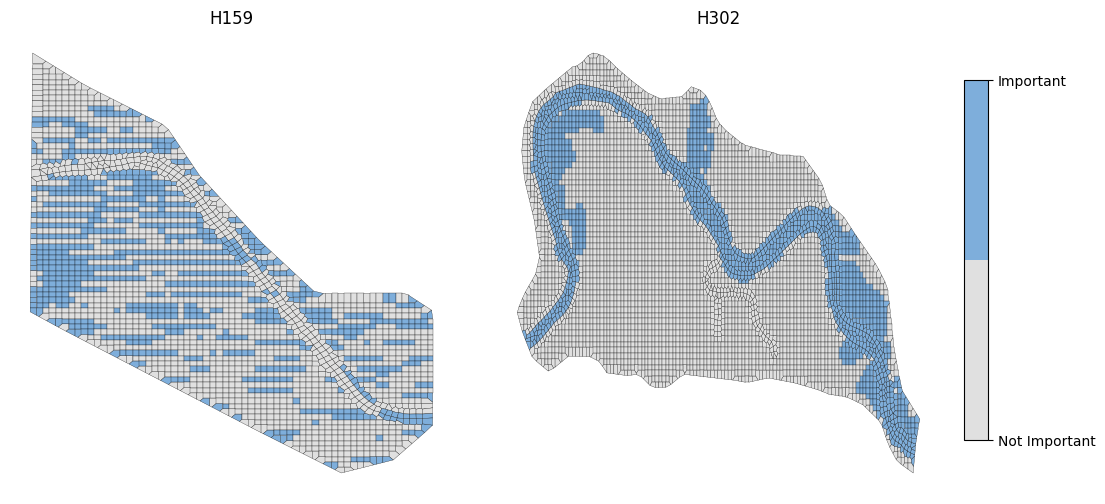

In [29]:
# pick two simulation files by index
iowa_sim_idx =69
white_sim_idx = 70
iowa_sim  = simulation_files[iowa_sim_idx]   # e.g. 69
white_sim = simulation_files[white_sim_idx]  # e.g. 70

configs = [
    ( iowa_sim,
      Path("/home/jtb3sud/G-PARC/demos/mesh_cells/Flood_GNN.p01.hdf"),
      "Geometry/2D Flow Areas/Flow Area/FacePoints Coordinate",
      "Geometry/2D Flow Areas/Flow Area/Cells FacePoint Indexes"
    ),
    ( white_sim,
      Path("/home/jtb3sud/G-PARC/demos/mesh_cells/Muncie2D_SI.p02.hdf"),
      "Geometry/2D Flow Areas/Perimeter 1/FacePoints Coordinate",
      "Geometry/2D Flow Areas/Perimeter 1/Cells FacePoint Indexes"
    )
]

visualize_simulations_side_by_side(
    configs,
    num_static_feats=9,
    pred_idx=0,
    threshold=0.0,
    save_path=Path("iowa_vs_white.png")
)


In [30]:
import pickle
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.colors import Normalize
import h5py

def visualize_nonimportant_error_single_step(
    sim_file: Path,
    model: torch.nn.Module,
    device: torch.device,
    num_static_feats: int,
    pred_idx: int,
    mesh_hdf_path: Path,
    facepts_ds: str,
    cells_ds: str,
    threshold: float = 0.0,
    timestep: int = -1,
    save_path: Path = None
):
    """
    Visualize absolute error for non-important nodes at a single timestep,
    plotted on the true mesh via PolyCollection.
    """
    # 1) Load simulation graphs
    graphs = pickle.load(open(sim_file, 'rb'))
    T = len(graphs) - 1
    if timestep < 0:
        timestep = T + timestep + 1
    if not (1 <= timestep <= T):
        raise ValueError(f"timestep={timestep} out of range 1..{T}")

    # 2) Compute important mask (denormalized) and its inverse
    important_mask = get_important_mask(graphs, num_static_feats, pred_idx, threshold)
    nonimp_mask    = ~important_mask

    # 3) Roll model forward to the requested timestep
    current = graphs[0].clone().to(device)
    y_min, y_max = y_mins[pred_idx], y_maxs[pred_idx]
    for t in range(1, timestep+1):
        with torch.no_grad():
            F_pred = model([current])[0]  # [n_nodes, n_dyn_feats]
        updated = current.clone()
        x_new   = updated.x.clone()
        x_new[:, num_static_feats:] = F_pred
        updated.x = x_new
        current = updated

    # 4) Extract & denormalize predictions and GT
    pred_norm = F_pred[:, pred_idx].cpu()
    gt_norm   = (graphs[timestep].y[:, pred_idx] 
                 if hasattr(graphs[timestep], 'y') 
                 else graphs[timestep].x[:, num_static_feats+pred_idx]).cpu()
    pred_phys = (pred_norm * (y_max - y_min) + y_min).numpy()
    gt_phys   = (gt_norm  * (y_max - y_min) + y_min).numpy()

    # absolute error, but zero out important nodes
    error_all = np.abs(pred_phys - gt_phys)
    error_all[important_mask.cpu().numpy()] = 0.0

    # 5) Load mesh geometry
    with h5py.File(mesh_hdf_path, 'r') as f:
        facepts = f[facepts_ds][:]
        cells   = f[cells_ds][:]

    # 6) Build polygons and per-cell error
    polys, errs = [], []
    for cell_idx, vid_arr in enumerate(cells):
        valid = (vid_arr >= 0) & (vid_arr < len(facepts))
        pts   = facepts[vid_arr[valid].astype(int)]
        if len(pts) < 3:
            continue
        polys.append(pts)
        errs.append(error_all[cell_idx])
    errs = np.array(errs)

    # 7) Plot with PolyCollection
    fig, ax = plt.subplots(figsize=(8,6))
    norm = Normalize(vmin=0, vmax=errs.max() if errs.size else 1e-6)
    pc = PolyCollection(
        polys,
        array=errs,
        cmap='Reds',
        edgecolors='k',
        linewidths=0.2,
        norm=norm
    )
    ax.add_collection(pc)
    ax.autoscale_view()
    ax.axis('off')
    ax.set_title(f"Error on Non-Important Nodes\n{sim_file.stem}  Timestep {timestep}", fontsize=14)

    # colorbar
    cbar = fig.colorbar(pc, ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label("Absolute Error", fontsize=10)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()


In [31]:
import pickle
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.colors import Normalize
import h5py


def visualize_four_simulations_error(
    configs,
    model: torch.nn.Module,
    device: torch.device,
    num_static_feats: int,
    pred_idx: int,
    threshold: float = 0.0,
    timestep: int = -1,
    save_path: Path = None
):
    """
    configs: list of exactly 4 tuples
      (sim_file: Path,
       mesh_hdf_path: Path,
       facepts_ds: str,
       cells_ds: str)

    Plots absolute error in meters for non-important nodes at a given timestep
    on four simulations side by side, printing key metrics per simulation.
    """
    if len(configs) != 4:
        raise ValueError("Must pass exactly 4 configs")

    sim_data = []
    for sim_file, mesh_hdf, facepts_ds, cells_ds in configs:
        # Load graphs and determine timestep
        graphs = pickle.load(open(sim_file, 'rb'))
        T = len(graphs) - 1
        if T < 1:
            raise ValueError(f"{sim_file} has no rollout steps.")
        ts = T if timestep < 0 else max(1, min(timestep, T))

        # Compute important/non-important masks
        imp_mask = get_important_mask(graphs, num_static_feats, pred_idx, threshold)
        nonimp = ~imp_mask

        # Roll the model forward
        current = graphs[0].clone().to(device)
        for t in range(1, ts + 1):
            with torch.no_grad():
                F_pred = model([current])[0]
            x_new = current.x.clone()
            x_new[:, num_static_feats:] = F_pred
            current = current.clone(); current.x = x_new

        # Denormalize predictions and ground truth
        y_min = float(y_mins[pred_idx]); y_max = float(y_maxs[pred_idx])
        p_norm = F_pred[:, pred_idx].cpu().numpy()
        g_tensor = (graphs[ts].y[:, pred_idx] if hasattr(graphs[ts], 'y')
                    else graphs[ts].x[:, num_static_feats + pred_idx])
        g_norm = g_tensor.cpu().numpy()
        p_phys = p_norm * (y_max - y_min) + y_min
        g_phys = g_norm * (y_max - y_min) + y_min

        # Absolute error on non-important nodes
        error = np.abs(p_phys - g_phys)
        error[imp_mask.cpu().numpy()] = 0.0

        # Compute and print metrics
        local_max = float(error.max()) if error.size else 0.0
        max_depth = float(g_phys.max()) if g_phys.size else 0.0
        pct = 100 * local_max / max_depth if max_depth > 0 else float('nan')
        print(f"{sim_file.stem}: max unimportant error = {local_max:.3f} m; "
              f"max depth = {max_depth:.3f} m; "
              f"{pct:.1f}% of peak depth")

        # Load mesh geometry
        with h5py.File(mesh_hdf, 'r') as f:
            facepts = f[facepts_ds][:]
            cells = f[cells_ds][:]

        # Build polygons and collect error per cell
        polys, errs = [], []
        for ci, vids in enumerate(cells):
            valid = (vids >= 0) & (vids < len(facepts))
            pts = facepts[vids[valid].astype(int)]
            if len(pts) < 3:
                continue
            polys.append(pts)
            errs.append(error[ci])
        errs = np.array(errs)

        sim_data.append((polys, errs, ts, sim_file.stem))

    # Plot four subplots with local scaling
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    plt.subplots_adjust(wspace=0.3)
    for ax, (polys, errs, ts, name) in zip(axes, sim_data):
        local_max = float(errs.max()) if errs.size else 1e-6
        norm = Normalize(vmin=0, vmax=local_max)
        pc = PolyCollection(
            polys,
            array=errs,
            cmap="Reds",
            edgecolors="k",
            linewidths=0.2,
            norm=norm
        )
        ax.add_collection(pc)
        ax.autoscale_view()
        ax.axis("off")
        ax.set_title(f"{name}\n(t={ts})", fontsize=10)
        cbar = fig.colorbar(pc, ax=ax, fraction=0.03, pad=0.04)
        cbar.set_label("|Pred−GT| (non-important)", fontsize=8)

    fig.suptitle("Unimportant-Node Error Across Four Sims (Per-Sim Metrics)", fontsize=14, y=0.98)
    if save_path:
        fig.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()


H231: max unimportant error = 0.963 m; max depth = 4.208 m; 22.9% of peak depth
H232: max unimportant error = 0.972 m; max depth = 5.122 m; 19.0% of peak depth
H368: max unimportant error = 1.911 m; max depth = 4.408 m; 43.4% of peak depth
H372: max unimportant error = 1.911 m; max depth = 4.768 m; 40.1% of peak depth


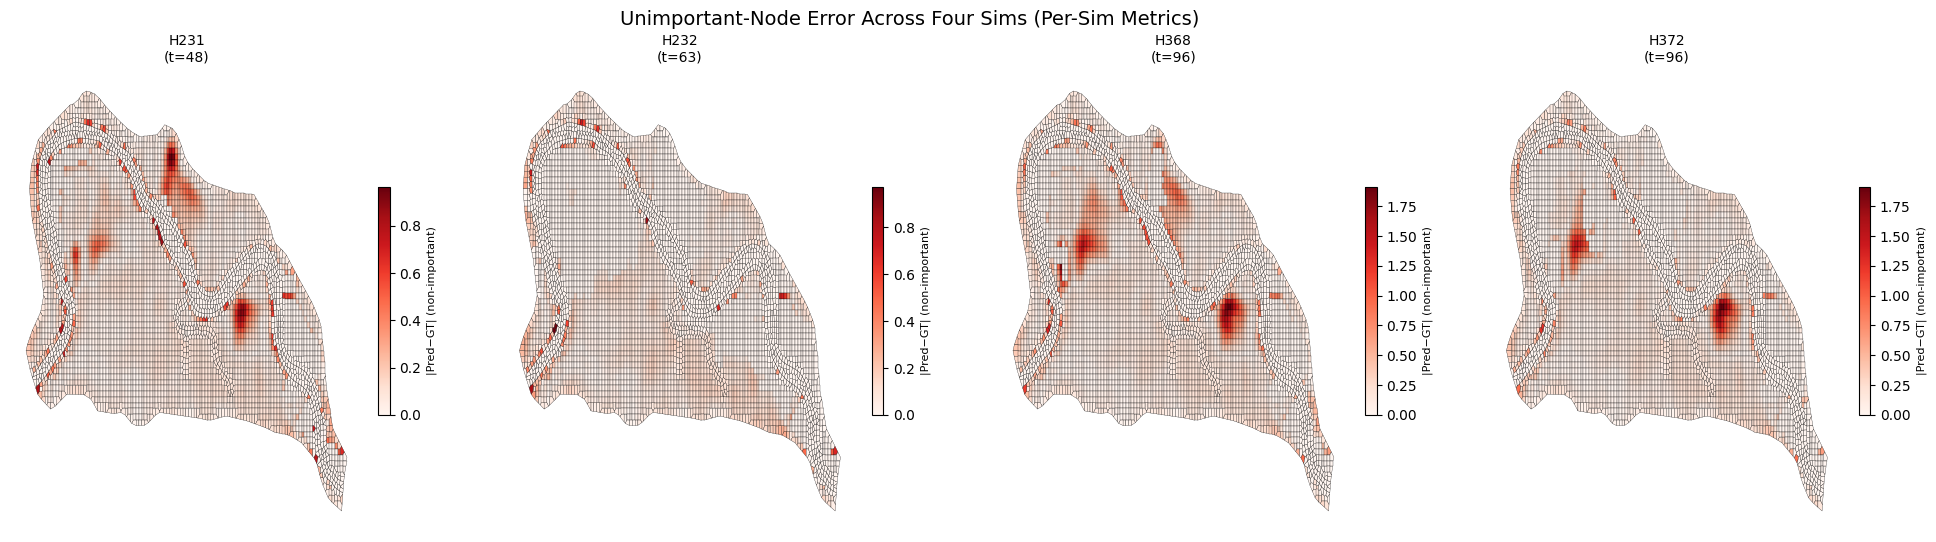

In [32]:
from pathlib import Path
import torch

# (1) Your four simulation pickles
my_four_files = [
    "/scratch/jtb3sud/combined/test/normalized/H231.pkl",
    "/scratch/jtb3sud/combined/test/normalized/H232.pkl",
    "/scratch/jtb3sud/combined/test/normalized/H368.pkl",
    "/scratch/jtb3sud/combined/test/normalized/H372.pkl"
]

# (2) White River mesh info
white_mesh_hdf = Path("/home/jtb3sud/G-PARC/demos/mesh_cells/Muncie2D_SI.p02.hdf")
facepts_white  = "Geometry/2D Flow Areas/Perimeter 1/FacePoints Coordinate"
cells_white    = "Geometry/2D Flow Areas/Perimeter 1/Cells FacePoint Indexes"

# (3) Build configs: one tuple per sim, each with its mesh parameters
configs = [
    (Path(sim), white_mesh_hdf, facepts_white, cells_white)
    for sim in my_four_files
]

# (4) Call the updated function
visualize_four_simulations_error(
    configs=configs,
    model=model,
    device=torch.device("cuda"),
    num_static_feats=9,
    pred_idx=0,
    threshold=0.0,
    timestep=-1,                 # last timestep
    save_path=Path("four_sims_error.png")
)


H147iw: max error = 0.436 m; max depth = 0.993 m; 43.9% of peak
H50: max error = 1.638 m; max depth = 4.628 m; 35.4% of peak


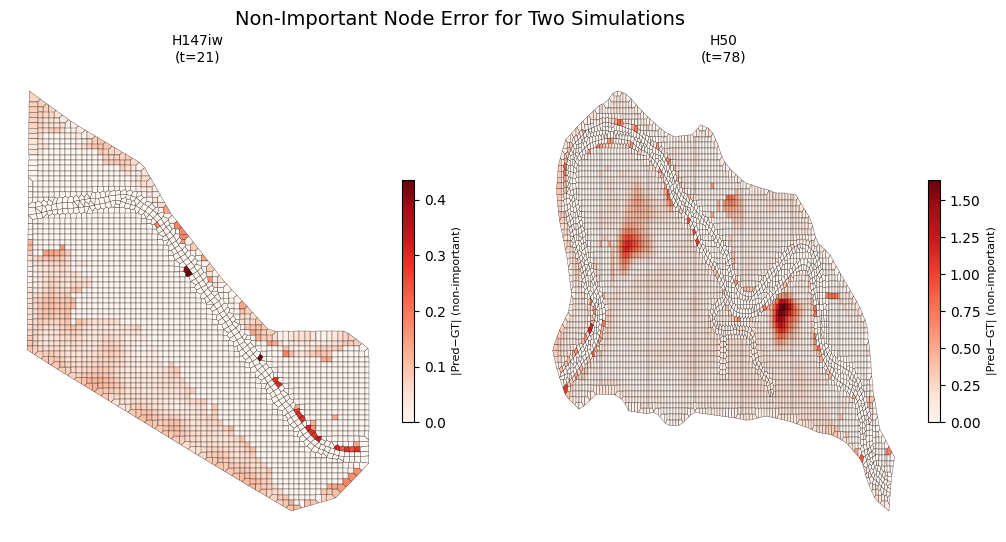

In [33]:
import pickle
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.colors import Normalize
import h5py

def visualize_two_simulations_error(
    configs,
    model: torch.nn.Module,
    device: torch.device,
    num_static_feats: int,
    pred_idx: int,
    threshold: float = 0.0,
    timestep: int = -1,
    save_path: Path = None
):
    """
    configs: list of exactly 2 tuples
      (sim_file: Path,
       mesh_hdf_path: Path,
       facepts_ds: str,
       cells_ds: str)
    Plots absolute error (|Pred−GT|) on non-important nodes for two simulations side-by-side,
    using their respective meshes, and prints max‐error metrics.
    """
    if len(configs) != 2:
        raise ValueError("Must pass exactly 2 configs")

    sim_data = []
    for sim_file, mesh_hdf, facepts_ds, cells_ds in configs:
        # Load simulation and pick timestep
        graphs = pickle.load(open(sim_file, 'rb'))
        T = len(graphs) - 1
        if T < 1:
            raise ValueError(f"{sim_file} has no rollout steps.")
        ts = T if timestep < 0 else max(1, min(timestep, T))

        # Build masks
        imp_mask = get_important_mask(graphs, num_static_feats, pred_idx, threshold)
        nonimp = ~imp_mask

        # Roll model forward
        current = graphs[0].clone().to(device)
        for t in range(1, ts + 1):
            with torch.no_grad():
                F_pred = model([current])[0]
            x_new = current.x.clone()
            x_new[:, num_static_feats:] = F_pred
            current = current.clone(); current.x = x_new

        # Denormalize
        y_min = float(y_mins[pred_idx]); y_max = float(y_maxs[pred_idx])
        p_norm = F_pred[:, pred_idx].cpu().numpy()
        g_tensor = (graphs[ts].y[:, pred_idx]
                    if hasattr(graphs[ts], 'y')
                    else graphs[ts].x[:, num_static_feats + pred_idx])
        g_norm = g_tensor.cpu().numpy()
        p_phys = p_norm * (y_max - y_min) + y_min
        g_phys = g_norm * (y_max - y_min) + y_min

        # Compute non-important error
        error = np.abs(p_phys - g_phys)
        error[imp_mask.cpu().numpy()] = 0.0

        # Print metrics
        local_max = float(error.max()) if error.size else 0.0
        max_depth = float(g_phys.max()) if g_phys.size else 0.0
        pct = 100 * local_max / max_depth if max_depth > 0 else float('nan')
        print(f"{sim_file.stem}: max error = {local_max:.3f} m; "
              f"max depth = {max_depth:.3f} m; {pct:.1f}% of peak")

        # Load mesh
        with h5py.File(mesh_hdf, 'r') as f:
            facepts = f[facepts_ds][:]
            cells = f[cells_ds][:]

        # Build polygons & per-cell error
        polys, errs = [], []
        for ci, vids in enumerate(cells):
            valid = (vids >= 0) & (vids < len(facepts))
            pts = facepts[vids[valid].astype(int)]
            if len(pts) < 3:
                continue
            polys.append(pts)
            errs.append(error[ci])
        errs = np.array(errs)

        sim_data.append((polys, errs, ts, sim_file.stem))

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.3)
    for ax, (polys, errs, ts, name) in zip(axes, sim_data):
        local_max = float(errs.max()) if errs.size else 1e-6
        norm = Normalize(vmin=0, vmax=local_max)
        pc = PolyCollection(
            polys,
            array=errs,
            cmap="Reds",
            edgecolors="k",
            linewidths=0.2,
            norm=norm
        )
        ax.add_collection(pc)
        ax.autoscale_view()
        ax.axis("off")
        ax.set_title(f"{name}\n(t={ts})", fontsize=10)
        cbar = fig.colorbar(pc, ax=ax, fraction=0.03, pad=0.04)
        cbar.set_label("|Pred−GT| (non-important)", fontsize=8)

    fig.suptitle("Non-Important Node Error for Two Simulations", fontsize=14, y=0.98)
    if save_path:
        fig.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()


# Example usage:

from pathlib import Path
import torch

# Two simulation pickles
my_two_files = [
    "/scratch/jtb3sud/combined/test/normalized/H147iw.pkl",  # Iowa
    "/scratch/jtb3sud/combined/test/normalized/H50.pkl"      # White
]

# Mesh info for Iowa and White
iowa_mesh = Path("/home/jtb3sud/G-PARC/demos/mesh_cells/Flood_GNN.p01.hdf")
facepts_iowa = "Geometry/2D Flow Areas/Flow Area/FacePoints Coordinate"
cells_iowa   = "Geometry/2D Flow Areas/Flow Area/Cells FacePoint Indexes"

white_mesh = Path("/home/jtb3sud/G-PARC/demos/mesh_cells/Muncie2D_SI.p02.hdf")
facepts_white = "Geometry/2D Flow Areas/Perimeter 1/FacePoints Coordinate"
cells_white   = "Geometry/2D Flow Areas/Perimeter 1/Cells FacePoint Indexes"

configs = [
    (Path(my_two_files[0]), iowa_mesh, facepts_iowa, cells_iowa),
    (Path(my_two_files[1]), white_mesh, facepts_white, cells_white),
]

visualize_two_simulations_error(
    configs=configs,
    model=model,
    device=torch.device("cuda"),
    num_static_feats=9,
    pred_idx=0,
    threshold=0.0,
    timestep=-1,                    # last step
    save_path=Path("two_sims_error.png")
)


In [34]:
import os
import shutil
import tempfile
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.collections import PolyCollection
from matplotlib.colors import Normalize
import h5py
import imageio

def make_gif_of_error(
    sim_file: Path,
    model: torch.nn.Module,
    device: torch.device,
    num_static_feats: int,
    pred_idx: int,
    mesh_hdf_path: Path,
    facepts_ds: str,
    cells_ds: str,
    threshold: float = 0.0,
    gif_path: Path = Path("simulation_error.gif"),
    duration: float = 0.5
):
    """
    Creates a GIF showing the absolute error for unimportant nodes over all timesteps
    in a single simulation file, with a consistent color bar across frames.
    """
    # 1. Load simulation graphs
    with open(sim_file, 'rb') as f:
        graphs = pickle.load(f)
    num_steps = len(graphs) - 1
    if num_steps < 1:
        print(f"No rollout steps in {sim_file}, no GIF created.")
        return

    # 2. Compute masks
    imp_mask = get_important_mask(graphs, num_static_feats, pred_idx, threshold)
    nonimp_mask = ~imp_mask

    # 3. Rollout predictions
    current = graphs[0].clone().to(device)
    preds = []
    for t in range(1, num_steps + 1):
        with torch.no_grad():
            F_pred = model([current])[0]
        preds.append(F_pred.cpu().numpy())
        x_new = current.x.clone()
        x_new[:, num_static_feats:] = F_pred
        current = current.clone()
        current.x = x_new

    # 4. Compute errors and track global max
    errors_over_time = []
    global_max_error = 0.0
    y_min = float(y_mins[pred_idx]); y_max = float(y_maxs[pred_idx])

    for t in range(1, num_steps + 1):
        F_pred_np = preds[t-1][:, pred_idx]
        if hasattr(graphs[t], 'y'):
            g_norm = graphs[t].y[:, pred_idx].cpu().numpy()
        else:
            g_norm = graphs[t].x[:, num_static_feats + pred_idx].cpu().numpy()
        p_phys = F_pred_np * (y_max - y_min) + y_min
        g_phys = g_norm * (y_max - y_min) + y_min
        node_error = np.zeros_like(p_phys)
        node_error[nonimp_mask.cpu().numpy()] = np.abs(p_phys[nonimp_mask.cpu().numpy()] - 
                                                       g_phys[nonimp_mask.cpu().numpy()])
        errors_over_time.append(node_error)
        local_max = node_error[nonimp_mask.cpu().numpy()].max() if any(nonimp_mask) else 0.0
        global_max_error = max(global_max_error, local_max)

    # 5. Load static mesh geometry
    with h5py.File(mesh_hdf_path, 'r') as f:
        facepts = f[facepts_ds][:]
        cells   = f[cells_ds][:]

    # 6. Prepare temporary directory for frames
    temp_dir = tempfile.mkdtemp(prefix="err_frames_")
    frame_paths = []

    # 7. Generate each frame
    triangulation = None  # unused now
    for t, node_error in enumerate(errors_over_time, start=1):
        # Build polys & per-cell error
        polys, errs = [], []
        for ci, vids in enumerate(cells):
            valid = (vids >= 0) & (vids < len(facepts))
            pts = facepts[vids[valid].astype(int)]
            if len(pts) < 3:
                continue
            polys.append(pts)
            errs.append(node_error[ci])
        errs = np.array(errs)

        fig, ax = plt.subplots(figsize=(6,5))
        norm = Normalize(vmin=0, vmax=global_max_error)
        pc = PolyCollection(
            polys,
            array=errs,
            cmap="Reds",
            edgecolors="k",
            linewidths=0.2,
            norm=norm
        )
        ax.add_collection(pc)
        ax.autoscale_view()
        ax.axis('off')
        ax.set_title(f"{sim_file.stem}  Timestep {t}", fontsize=12)

        sm = plt.cm.ScalarMappable(norm=norm, cmap="Reds")
        sm.set_array([])
        fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04).set_label(
            "|Pred − GT| (non-important, m)", fontsize=9
        )

        frame_path = os.path.join(temp_dir, f"frame_{t:03d}.png")
        plt.savefig(frame_path, bbox_inches='tight', dpi=150)
        plt.close(fig)
        frame_paths.append(frame_path)

    # 8. Write frames to GIF
    with imageio.get_writer(str(gif_path), mode='I', duration=duration, loop=0) as writer:
        for fp in frame_paths:
            writer.append_data(imageio.imread(fp))
    print(f"GIF saved to {gif_path}")

    # 9. Cleanup
    shutil.rmtree(temp_dir)
    print(f"Removed temporary frames in {temp_dir}")


In [35]:
make_gif_of_error(
    sim_file=Path("/scratch/jtb3sud/combined/test/normalized/H147iw.pkl"),
    model=model,
    device=torch.device("cuda"),
    num_static_feats=9,
    pred_idx=0,
    mesh_hdf_path=Path("/home/jtb3sud/G-PARC/demos/mesh_cells/Flood_GNN.p01.hdf"),
    facepts_ds="Geometry/2D Flow Areas/Flow Area/FacePoints Coordinate",
    cells_ds="Geometry/2D Flow Areas/Flow Area/Cells FacePoint Indexes",
    threshold=0.0,
    gif_path=Path("iowa_error.gif"),
    duration=0.5
)


/tmp/ipykernel_230759/2019427466.py:127: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(fp))


GIF saved to iowa_error.gif
Removed temporary frames in /tmp/err_frames_db_uzykj


Aggregated Water Depth [0] over 111 timesteps
Aggregated Volume [1] over 111 timesteps
Aggregated Velocity X [2] over 111 timesteps
Aggregated Velocity Y [3] over 111 timesteps
Determined segments: [(1, 22), (22, 64), (64, 79), (79, 97), (97, 112)]
Figure saved as four_vars_segments_physical.png


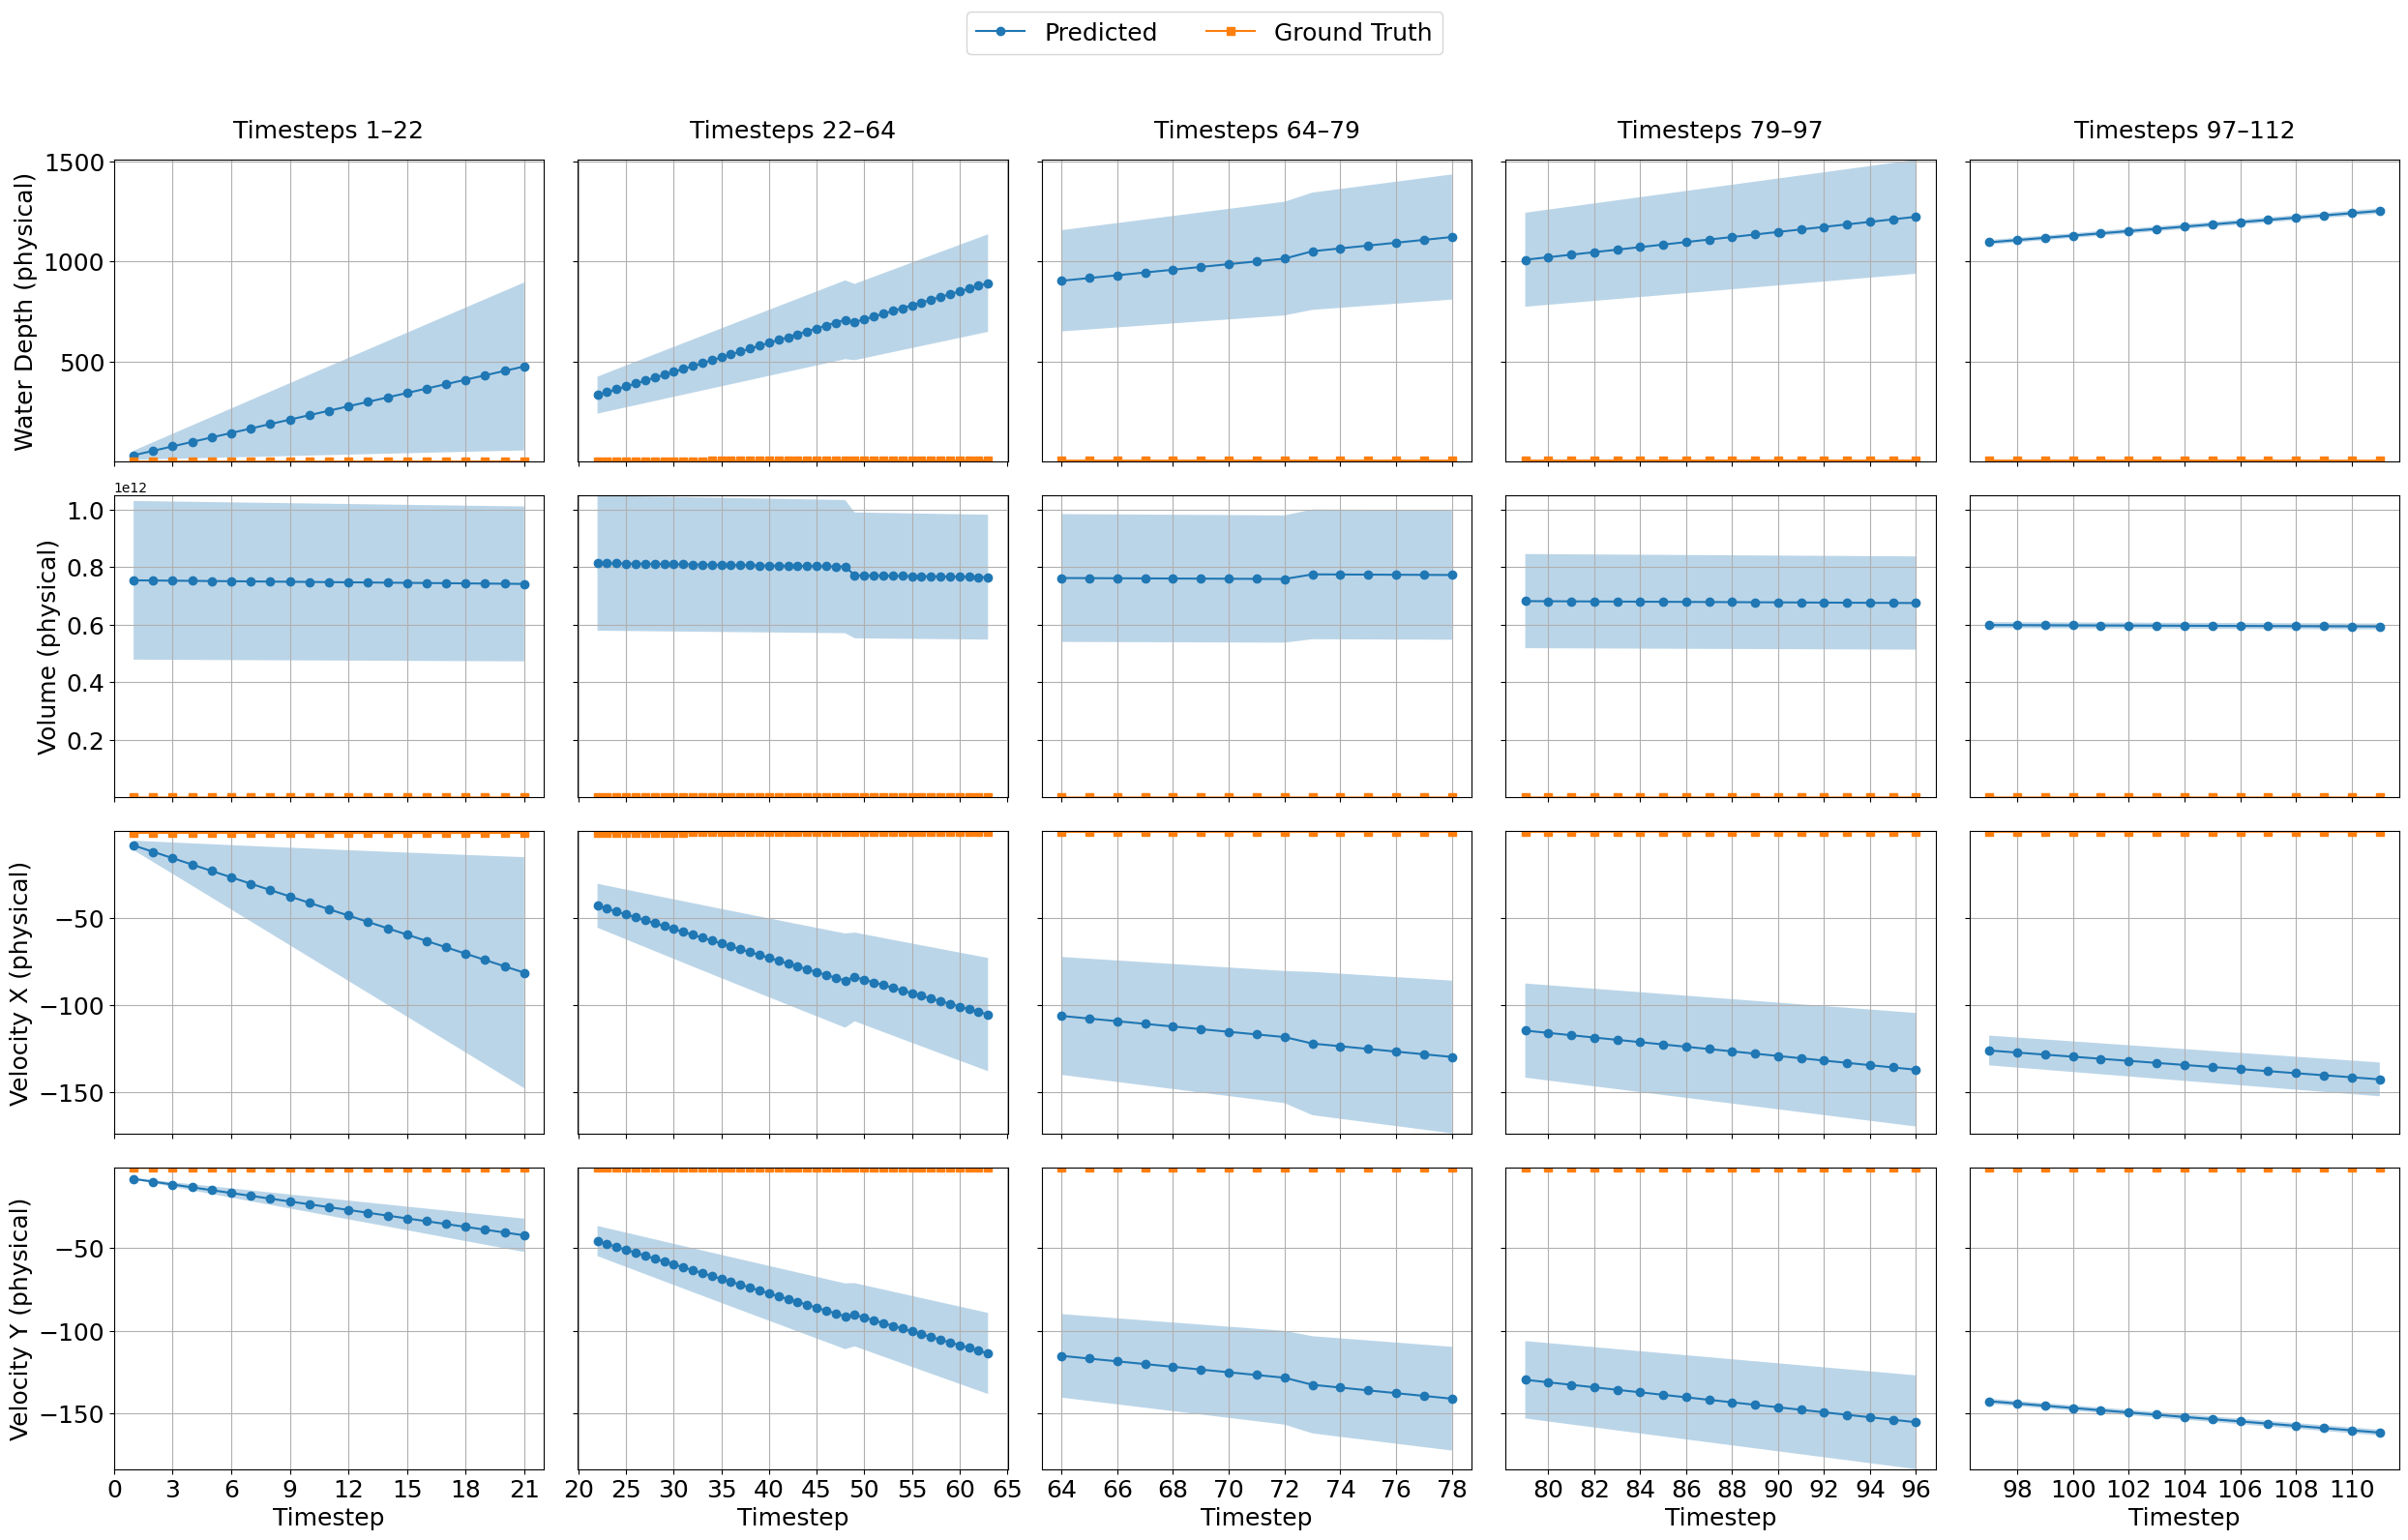

Figure saved as height_volume_segments_physical.png


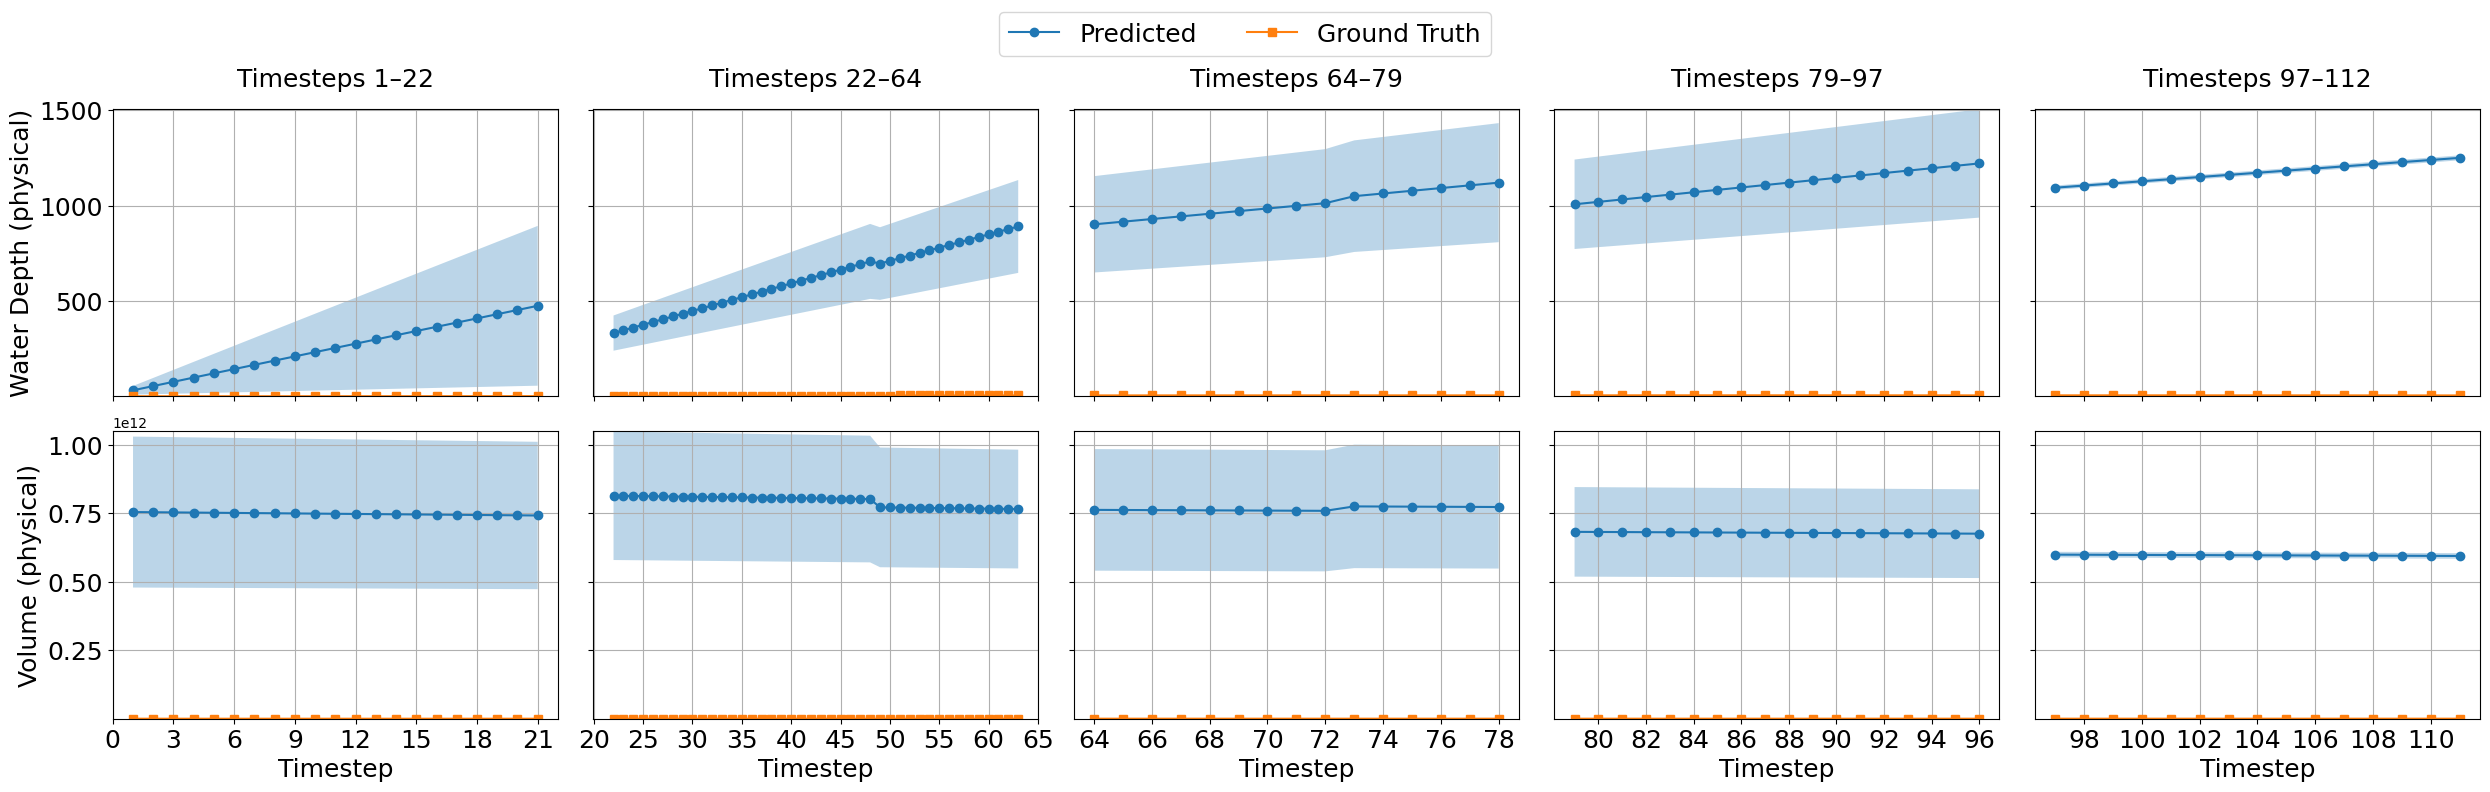

Figure saved as velocity_segments_physical.png


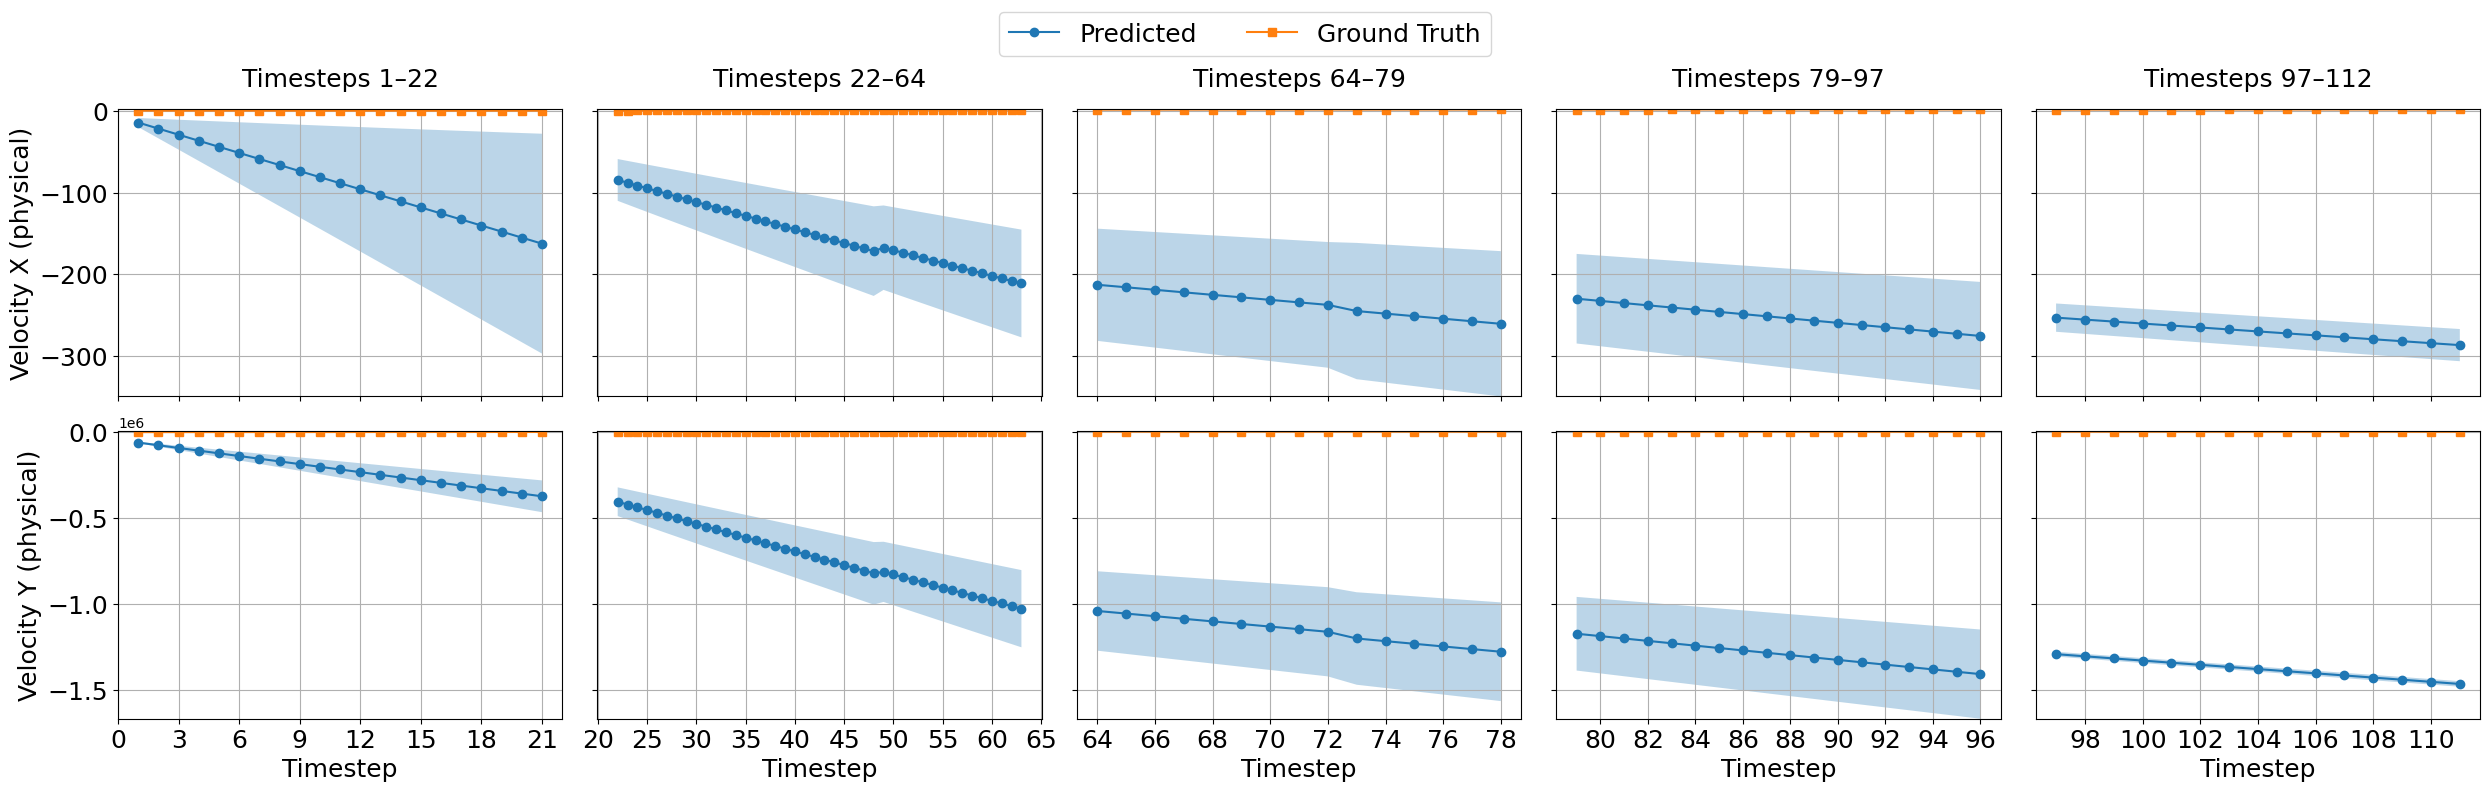

In [36]:
import math
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# Ensure you have access to the denormalization extrema
# from your global scope:
# y_mins, y_maxs = ...

def plot_segments_grid_multiple_variables(
    timesteps,
    list_pred_means,
    list_pred_stds,
    list_gt_means,
    list_gt_stds,
    list_feature_names,
    segments,
    output_filename="multi_segments_plot.png"
):
    """
    Plots time segments as subplots in one figure for multiple dynamic variables.
    Each row is one variable (with its own y-axis scale in physical units),
    each column is one time segment. Only the left column shows Y-ticks, only
    the bottom row shows X-ticks, and a common legend is placed at top.
    """
    title_size = 18
    label_size = 18
    tick_size  = 18
    legend_size= 18

    n_vars      = len(list_pred_means)
    num_segments= len(segments)
    if num_segments == 0:
        print("No segments to plot.")
        return

    fig, axes = plt.subplots(
        n_vars, num_segments,
        figsize=(num_segments * 5, n_vars * 4),
        squeeze=False, sharey='row'
    )

    common_handles, common_labels = None, None

    for i in range(n_vars):
        # denormalize for this variable
        y_min = float(y_mins[i])
        y_max = float(y_maxs[i])
        scale = y_max - y_min

        pm = list_pred_means[i] * scale + y_min
        ps = list_pred_stds[i] * scale
        gm = list_gt_means[i]   * scale + y_min
        gs = list_gt_stds[i]    * scale
        feature_name = list_feature_names[i]

        # compute row‐wise y‐limits
        y_low  = min((pm - ps).min(), (gm - gs).min())
        y_high = max((pm + ps).max(), (gm + gs).max())

        for j, (start, end) in enumerate(segments):
            ax = axes[i][j]
            idx = np.where((timesteps >= start) & (timesteps < end))[0]
            if idx.size == 0:
                ax.axis('off')
                continue

            l1, = ax.plot(timesteps[idx], pm[idx], marker='o', label="Predicted")
            ax.fill_between(timesteps[idx], pm[idx]-ps[idx], pm[idx]+ps[idx], alpha=0.3)
            l2, = ax.plot(timesteps[idx], gm[idx], marker='s', label="Ground Truth")
            ax.fill_between(timesteps[idx], gm[idx]-gs[idx], gm[idx]+gs[idx], alpha=0.3)

            if i == 0:
                ax.set_title(f"Timesteps {start}–{end}", fontsize=title_size, pad=16)
                common_handles, common_labels = [l1, l2], ["Predicted", "Ground Truth"]

            if i == n_vars - 1:
                ax.set_xlabel("Timestep", fontsize=label_size)
            else:
                ax.tick_params(axis='x', labelbottom=False)

            if j == 0:
                ax.set_ylabel(f"{feature_name} (physical)", fontsize=label_size)
            else:
                ax.tick_params(axis='y', labelleft=False)

            ax.set_ylim(y_low, y_high)
            ax.grid(True)
            ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
            ax.tick_params(axis='both', labelsize=tick_size)

    if common_handles:
        fig.legend(common_handles, common_labels, loc="upper center", ncol=2, fontsize=legend_size)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    print(f"Figure saved as {output_filename}")
    plt.show()


# -----------------------------
# Aggregation & Plotting Cell
# -----------------------------
# After importing y_mins, y_maxs and your model & data:

list_pred_means, list_pred_stds = [], []
list_gt_means,   list_gt_stds   = [], []
list_feature_names = []

for pred_idx in range(4):
    # Aggregate (returns normalized arrays)
    timesteps, pm, ps, gm, gs, fname = aggregate_avg_values_variable_return(
        simulation_files, feature_extractor, model, device, num_static_feats, pred_idx
    )
    print(f"Aggregated {fname} [{pred_idx}] over {len(timesteps)} timesteps")

    list_pred_means.append(pm)
    list_pred_stds.append(ps)
    list_gt_means.append(gm)
    list_gt_stds.append(gs)
    list_feature_names.append(fname)

# Determine segments once
segments, counts, lengths = determine_time_segments(simulation_files, min_segment_length=10, drop_threshold=0.8)
print(f"Determined segments: {segments}")

# Plot all four variables
plot_segments_grid_multiple_variables(
    timesteps,
    list_pred_means,
    list_pred_stds,
    list_gt_means,
    list_gt_stds,
    list_feature_names,
    segments,
    output_filename="four_vars_segments_physical.png"
)

# Split into Height/Volume and Velocity groups as before, but values are now physical
plot_segments_grid_multiple_variables(
    timesteps,
    list_pred_means[0:2],
    list_pred_stds[0:2],
    list_gt_means[0:2],
    list_gt_stds[0:2],
    list_feature_names[0:2],
    segments,
    output_filename="height_volume_segments_physical.png"
)

plot_segments_grid_multiple_variables(
    timesteps,
    list_pred_means[2:4],
    list_pred_stds[2:4],
    list_gt_means[2:4],
    list_gt_stds[2:4],
    list_feature_names[2:4],
    segments,
    output_filename="velocity_segments_physical.png"
)


In [37]:
import pickle
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.colors import Normalize
import h5py

Y_FEATURE_MAPPING = {
    0: "Water Depth",
    1: "Volume",
    2: "Velocity X",
    3: "Velocity Y"
}

def plot_still_images_for_feature(
    file_path: Path,
    model: torch.nn.Module,
    device: torch.device,
    pred_idx: int,
    mesh_hdf_path: Path,
    facepts_ds: str,
    cells_ds: str,
    num_static_feats: int = 9,
    n_samples: int = 5,
    max_timesteps: int = 200,
    output_filename: Path = None
):
    if output_filename is None:
        output_filename = file_path.with_name(f"{file_path.stem}_feat{pred_idx}.png")

    # 1) Load graphs
    with open(file_path, 'rb') as f:
        graphs = pickle.load(f)
    T = min(len(graphs) - 1, max_timesteps)
    if T < 1:
        print("Not enough timesteps.")
        return

    # 2) Rollout to collect normalized GT & pred
    current = graphs[0].clone().to(device)
    gt_list, pr_list = [], []
    for t in range(1, T + 1):
        with torch.no_grad():
            F_pred = model([current])[0]
        g = graphs[t]
        gt_norm = (g.y[:, pred_idx] if hasattr(g, 'y')
                   else g.x[:, num_static_feats + pred_idx])
        gt_list.append(gt_norm.cpu().numpy())
        pr_list.append(F_pred[:, pred_idx].cpu().numpy())
        # update state
        nx = current.x.clone()
        nx[:, num_static_feats:] = F_pred
        current = current.clone(); current.x = nx

    # 3) Denormalize
    y_min = float(y_mins[pred_idx])
    y_max = float(y_maxs[pred_idx])
    gt_phys = [arr * (y_max - y_min) + y_min for arr in gt_list]
    pr_phys = [arr * (y_max - y_min) + y_min for arr in pr_list]

    # 4) Load mesh
    with h5py.File(mesh_hdf_path, 'r') as f:
        facepts = f[facepts_ds][:]
        cells = f[cells_ds][:]

    # 5) Determine sample indices
    sample_idxs = np.linspace(0, T - 1, n_samples, dtype=int)

    # 6) Compute color scale across all sampled frames
    all_vals = np.concatenate(gt_phys + pr_phys)
    vmin = max(0.0, all_vals.min()) if pred_idx in [0, 1] else all_vals.min()
    vmax = all_vals.max()
    norm = Normalize(vmin=vmin, vmax=vmax)

    # 7) Build cell polygons once
    polys = []
    for verts in cells:
        valid = (verts >= 0) & (verts < len(facepts))
        pts = facepts[verts[valid].astype(int)]
        if len(pts) >= 3:
            polys.append(pts)

    feature_name = Y_FEATURE_MAPPING[pred_idx]
    fig, axes = plt.subplots(2, n_samples, figsize=(n_samples * 4, 8), constrained_layout=False)
    fig.subplots_adjust(top=0.85, hspace=0.01, wspace=0.01)

    for col, idx in enumerate(sample_idxs):
        # Top row: Ground Truth
        ax_gt = axes[0, col]
        vals_gt = gt_phys[idx]
        errs_gt = [vals_gt[i] for i in range(len(polys))]
        pc_gt = PolyCollection(
            polys,
            array=np.array(errs_gt),
            cmap="viridis",
            edgecolors="k",
            linewidths=0.2,
            norm=norm
        )
        ax_gt.add_collection(pc_gt)
        ax_gt.autoscale_view()
        ax_gt.axis('off')
        ax_gt.set_title(f"T={idx+1}", fontsize=16, pad=5)

        # Bottom row: Prediction
        ax_pr = axes[1, col]
        vals_pr = pr_phys[idx]
        errs_pr = [vals_pr[i] for i in range(len(polys))]
        pc_pr = PolyCollection(
            polys,
            array=np.array(errs_pr),
            cmap="viridis",
            edgecolors="k",
            linewidths=0.2,
            norm=norm
        )
        ax_pr.add_collection(pc_pr)
        ax_pr.autoscale_view()
        ax_pr.axis('off')

    # Row labels
    fig.text(0.045, 0.75, 'Ground Truth', va='center', ha='left', fontsize=18)
    fig.text(0.06, 0.35, 'Prediction', va='center', ha='left', fontsize=18)

    # Common colorbar
    sm = plt.cm.ScalarMappable(norm=norm, cmap="viridis")
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.02)
    cbar.set_label(f"{feature_name} (m)", fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    #fig.suptitle(f"{feature_name} Rollout", fontsize=22, y=1.02)

    if output_filename:
        plt.savefig(output_filename, bbox_inches="tight", dpi=300)
        print(f"Saved still image to {output_filename}")
    plt.show()


Saved still image to iowa_depth.png


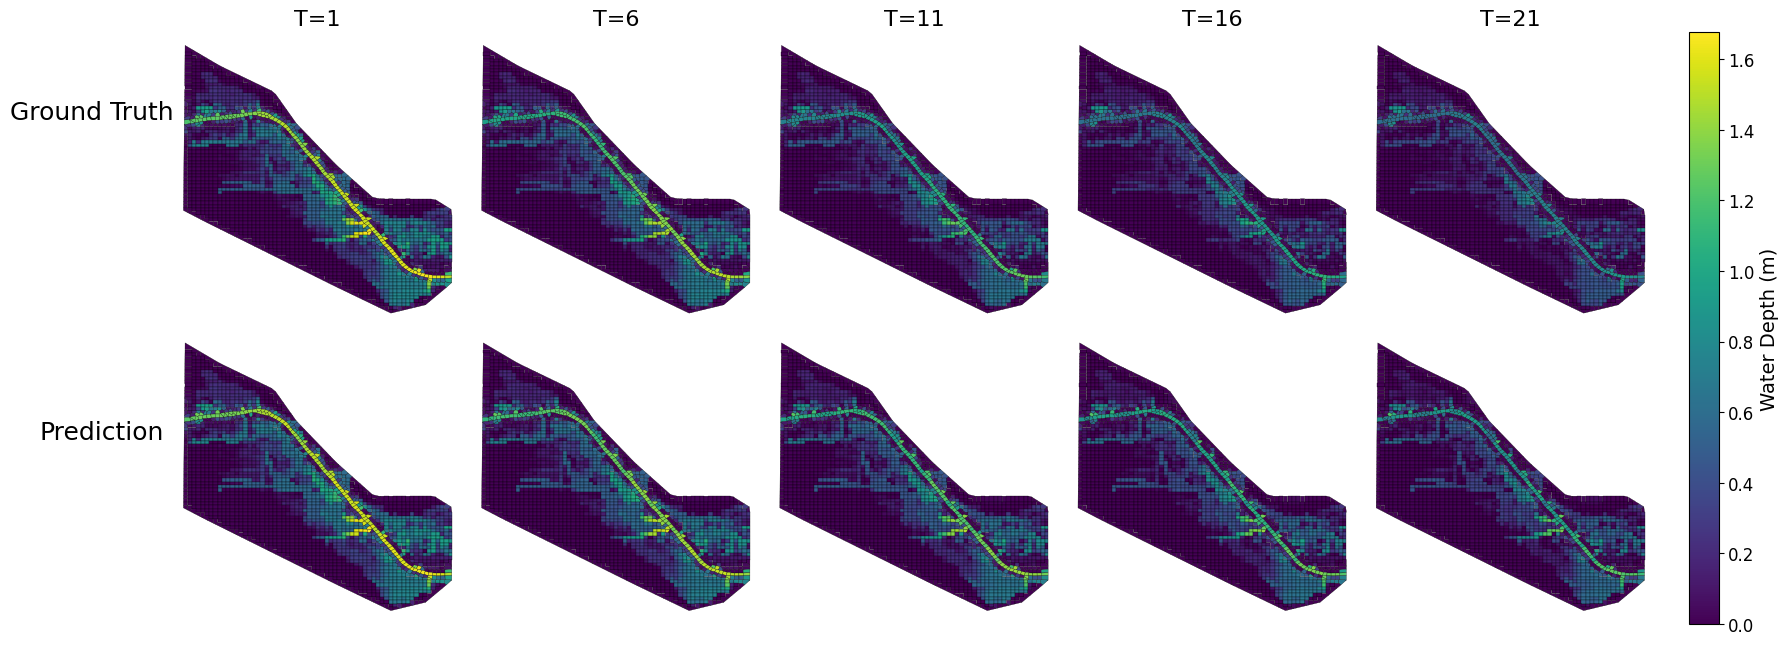

Saved still image to white_depth.png


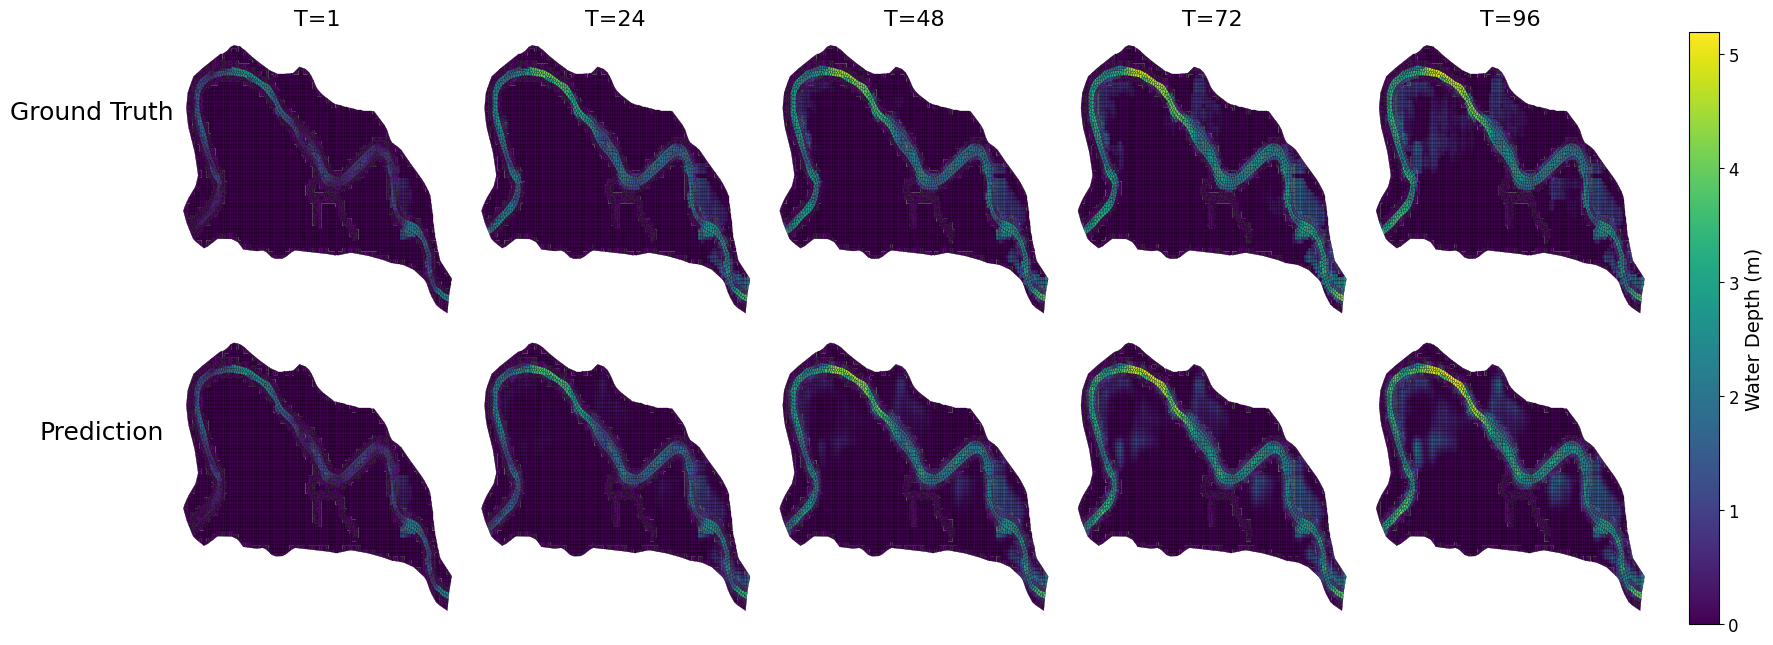

In [38]:
iowa_mesh = Path("/home/jtb3sud/G-PARC/demos/mesh_cells/Flood_GNN.p01.hdf")
face_iowa = "Geometry/2D Flow Areas/Flow Area/FacePoints Coordinate"
cells_iowa= "Geometry/2D Flow Areas/Flow Area/Cells FacePoint Indexes"

white_mesh = Path("/home/jtb3sud/G-PARC/demos/mesh_cells/Muncie2D_SI.p02.hdf")
face_white= "Geometry/2D Flow Areas/Perimeter 1/FacePoints Coordinate"
cells_white="Geometry/2D Flow Areas/Perimeter 1/Cells FacePoint Indexes"

sim_iowa  = Path("/scratch/jtb3sud/combined/test/normalized/H147iw.pkl")
sim_white = Path("/scratch/jtb3sud/combined/test/normalized/H379.pkl")

# Plot water depth for Iowa
plot_still_images_for_feature(sim_iowa, model, device, pred_idx=0,
                             mesh_hdf_path=iowa_mesh,
                             facepts_ds=face_iowa, cells_ds=cells_iowa,
                             output_filename=Path("iowa_depth.png"))

# Plot water depth for White
plot_still_images_for_feature(sim_white, model, device, pred_idx=0,
                             mesh_hdf_path=white_mesh,
                             facepts_ds=face_white, cells_ds=cells_white,
                             output_filename=Path("white_depth.png"))


# Velocity

In [ ]:
import pickle
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Dynamic variable names
y_feature_mapping = {
    0: "Water Depth",
    1: "Volume",
    2: "Velocity X",
    3: "Velocity Y"
}

def plot_correlation_side_by_side(
    simulation_files,
    model: torch.nn.Module,
    device: torch.device,
    num_static_feats: int,
    pred_indices,
    output_filename: Path = None
):
    """
    For each idx in pred_indices, runs through all sims, collects denormalized
    predictions vs ground truth inline, then plots GT vs Pred scatter with Pearson r.
    """
    n_plots = len(pred_indices)
    fig, axes = plt.subplots(1, n_plots, figsize=(n_plots * 6, 6), squeeze=False)
    axes = axes.ravel()

    for ax, pred_idx in zip(axes, pred_indices):
        # Denorm extrema
        y_min = float(y_mins[pred_idx]); y_max = float(y_maxs[pred_idx])
        scale = y_max - y_min

        all_preds, all_gts = [], []
        for sim_file in simulation_files:
            graphs = pickle.load(open(sim_file, 'rb'))
            # Inline evaluate: rollout each sim and collect values
            current = graphs[0].clone().to(device)
            steps = len(graphs) - 1
            for t in range(1, steps + 1):
                with torch.no_grad():
                    F_pred = model([current])[0]
                # ground truth norm
                g = graphs[t]
                gt_norm = g.y[:, pred_idx] if hasattr(g, 'y') else g.x[:, num_static_feats + pred_idx]
                # prediction norm
                pr_norm = F_pred[:, pred_idx]
                all_gts.extend(gt_norm.cpu().numpy().tolist())
                all_preds.extend(pr_norm.cpu().numpy().tolist())
                # update state
                x_new = current.x.clone()
                x_new[:, num_static_feats:] = F_pred
                current = current.clone(); current.x = x_new

        # Convert to numpy arrays and denormalize
        all_preds = np.array(all_preds) * scale + y_min
        all_gts  = np.array(all_gts)  * scale + y_min
        # Pearson r
        r = np.corrcoef(all_gts, all_preds)[0,1]

        # scatter
        ax.scatter(all_gts, all_preds, alpha=0.3)
        mn, mx = min(all_gts.min(), all_preds.min()), max(all_gts.max(), all_preds.max())
        ax.plot([mn, mx], [mn, mx], 'r--', linewidth=1)

        fname = y_feature_mapping.get(pred_idx, f"Var {pred_idx}")
        ax.set_title(f"{fname}\nPearson r = {r:.3f}", fontsize=14)
        ax.set_xlabel("Ground Truth (m/s)", fontsize=12)
        ax.set_ylabel("Prediction (m/s)", fontsize=12)
        ax.grid(True)

    plt.tight_layout()
    if output_filename:
        plt.savefig(output_filename, bbox_inches='tight', dpi=300)
        print(f"Saved correlation plot to {output_filename}")
    plt.show()

# Example usage:
simulation_files = list(Path("/scratch/jtb3sud/combined/test/normalized").glob("*.pkl"))
plot_correlation_side_by_side(
    simulation_files=simulation_files,
    model=model,
    device=torch.device("cuda"),
    num_static_feats=9,
    pred_indices=[2,3],  # Velocity X, Velocity Y
    output_filename=Path("velocity_correlation_physical.png")
)


Figure saved as velocity_correlation.png


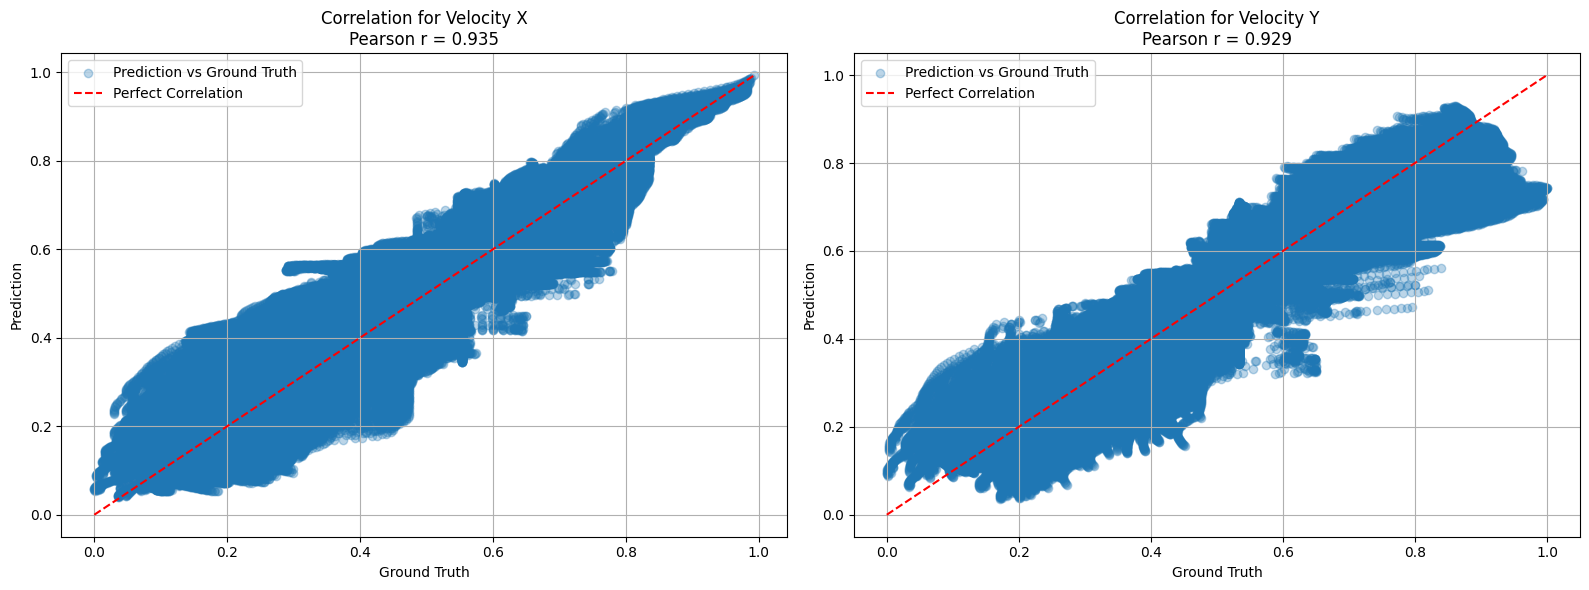

In [29]:
# Assuming simulation_files, feature_extractor, model, device, and num_static_feats are defined,
# and FEATURE_MAPPING contains entries for indices 2 and 3.
plot_correlation_side_by_side(
    simulation_files,
    feature_extractor,
    model,
    device,
    num_static_feats,
    pred_indices=[2, 3],
    output_filename="velocity_correlation.png"
)


# Inference Times

In [15]:
# ---------------------------- Import Necessary Modules ----------------------------

import time
from pathlib import Path
from tqdm.notebook import tqdm  # Use tqdm.notebook for Jupyter compatibility
import torch
import pickle
import numpy as np  # Ensure NumPy is imported
from torch_geometric.data import Data

# ---------------------------- Define Y_FEATURE_MAPPING ----------------------------

# Define Y_FEATURE_MAPPING to map feature indices to meaningful names
Y_FEATURE_MAPPING = {
    0: "Current Water Depth",
    1: "Current Volume",
    2: "Current Velocity X",
    3: "Current Velocity Y"
    # Add other mappings as needed
}

# ---------------------------- Define Helper Functions ----------------------------

def process_single_file(
    file_path: Path,
    feature_extractor: torch.nn.Module,
    model: torch.nn.Module,
    device: torch.device,
    pred_idx: int,
    max_timesteps: int = 100
) -> float:
    """
    Measures inference time by rolling out predictions from t=0.
    """
    print(f"Processing file: {file_path.name}")

    # Load graphs
    try:
        with open(file_path, 'rb') as f:
            graphs = pickle.load(f)
    except Exception as e:
        print(f"Failed to load {file_path.name}: {e}")
        return 0.0

    if not graphs:
        print(f"No graphs found in the file: {file_path.name}")
        return 0.0

    # Initialize graph
    current_graph = graphs[0].to(device)
    edge_index = current_graph.edge_index  # Edge index remains constant

    # (Optional) Precompute static features if needed elsewhere
    # Note: The model computes the static feature map internally.
    # static_feats_0 = current_graph.x[:, :9]
    # static_feature_map = feature_extractor(static_feats_0, edge_index)

    model.to(device)
    model.eval()
    total_inference_time = 0.0

    with torch.no_grad():
        for t in tqdm(range(min(len(graphs) - 1, max_timesteps)), desc=f"Inference {file_path.name}", leave=False):
            if device.type == 'cuda':
                torch.cuda.synchronize()
            start_time = time.perf_counter()

            # Model prediction with only the required argument (data_list)
            predictions = model([current_graph])
            F_pred = predictions[0]  # Extract first timestep

            if device.type == 'cuda':
                torch.cuda.synchronize()
            end_time = time.perf_counter()
            total_inference_time += (end_time - start_time)

            # Update graph with predictions
            current_graph = current_graph.clone()
            updated_x = current_graph.x.clone()
            updated_x[:, -4:] = F_pred  # Update only dynamic features
            current_graph.x = updated_x

    print(f"Completed file: {file_path.name} | Total Inference Time: {total_inference_time:.2f} seconds")
    return total_inference_time


def process_folder(
    folder_path: Path,
    model: torch.nn.Module,
    device: torch.device,
    pred_idx: int,
    max_timesteps: int = 100,
    output_file: Path = Path("inference_times.txt")
):
    """
    Processes all .pkl files in a folder, performs inference on each graph,
    measures inference time, and writes the time for each file to a text file.

    Args:
        folder_path (Path): Path to the folder containing .pkl files.
        model (torch.nn.Module): Trained PyTorch model.
        device (torch.device): Device to perform computations.
        pred_idx (int): Index of the feature to visualize.
        max_timesteps (int, optional): Maximum number of timesteps to predict per file. Defaults to 100.
        output_file (Path, optional): Path to the output text file. Defaults to "inference_times.txt".
    """
    if not folder_path.exists():
        print(f"The folder {folder_path} does not exist.")
        return

    if not folder_path.is_dir():
        print(f"The path {folder_path} is not a directory.")
        return

    # Gather all .pkl files in the folder
    pkl_files = list(folder_path.glob("*.pkl"))

    if not pkl_files:
        print(f"No .pkl files found in the folder: {folder_path}")
        return

    print(f"Found {len(pkl_files)} .pkl files in the folder: {folder_path}")

    # Open the output file in write mode
    with open(output_file, 'w') as f_out:
        # Iterate over all files
        for file_path in tqdm(pkl_files, desc="Processing files"):
            total_time = process_single_file(
                file_path=file_path,
                feature_extractor=feature_extractor,
                model=model,
                device=device,
                pred_idx=pred_idx,
                max_timesteps=max_timesteps
            )
            # Extract the hydrograph ID from the file name
            # Assuming file name is like H1.pkl, H2.pkl etc.
            hydrograph_id = file_path.stem  # Removes .pkl
            # Write to the text file
            f_out.write(f"Hydrograph {hydrograph_id}: {total_time:.2f} seconds\n")

    print(f"Inference times have been written to {output_file}")


In [22]:
# ---------------------------- Specify Folder Path and Parameters ----------------------------

# Specify the folder containing .pkl files
folder_path = Path("/scratch/jtb3sud/combined/train/normalized")  # Replace with your actual folder path

# Specify the feature index you want to visualize (e.g., 0 for "Current Water Depth")
pred_idx = 0

# Specify the maximum number of timesteps to predict per file
max_timesteps = 150  # Adjust based on your requirements

# Specify the output text file path
output_file = Path("/home/jtb3sud/G-PARC/demos/new_river/train_inference_times.txt")  # This will create the file in the current directory


In [23]:
print(device)

cuda


In [24]:
# ---------------------------- Execute the Processing ----------------------------

# Execute the processing function
process_folder(
    folder_path=folder_path,
    model=model,             # Your trained model
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    pred_idx=pred_idx,       # Feature index to visualize
    max_timesteps=max_timesteps,
    output_file=output_file  # Path to the output text file
)


Found 700 .pkl files in the folder: /scratch/jtb3sud/combined/train/normalized


Processing files:   0%|          | 0/700 [00:00<?, ?it/s]

Processing file: H103.pkl


Inference H103.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H103.pkl | Total Inference Time: 1.06 seconds
Processing file: H38.pkl


Inference H38.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H38.pkl | Total Inference Time: 1.29 seconds
Processing file: H17.pkl


Inference H17.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H17.pkl | Total Inference Time: 1.29 seconds
Processing file: H344iw.pkl


Inference H344iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H344iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H320.pkl


Inference H320.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H320.pkl | Total Inference Time: 1.53 seconds
Processing file: H384.pkl


Inference H384.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H384.pkl | Total Inference Time: 0.67 seconds
Processing file: H467.pkl


Inference H467.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H467.pkl | Total Inference Time: 1.31 seconds
Processing file: H76iw.pkl


Inference H76iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H76iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H323iw.pkl


Inference H323iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H323iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H233.pkl


Inference H233.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H233.pkl | Total Inference Time: 0.84 seconds
Processing file: H44iw.pkl


Inference H44iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H44iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H149.pkl


Inference H149.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H149.pkl | Total Inference Time: 1.13 seconds
Processing file: H475.pkl


Inference H475.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H475.pkl | Total Inference Time: 1.28 seconds
Processing file: H267iw.pkl


Inference H267iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H267iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H249iw.pkl


Inference H249iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H249iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H185iw.pkl


Inference H185iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H185iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H42iw.pkl


Inference H42iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H42iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H201.pkl


Inference H201.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H201.pkl | Total Inference Time: 0.97 seconds
Processing file: H408iw.pkl


Inference H408iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H408iw.pkl | Total Inference Time: 0.40 seconds
Processing file: H386.pkl


Inference H386.pkl:   0%|          | 0/111 [00:00<?, ?it/s]

Completed file: H386.pkl | Total Inference Time: 1.49 seconds
Processing file: H228.pkl


Inference H228.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H228.pkl | Total Inference Time: 0.86 seconds
Processing file: H381.pkl


Inference H381.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H381.pkl | Total Inference Time: 1.04 seconds
Processing file: H233iw.pkl


Inference H233iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H233iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H71iw.pkl


Inference H71iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H71iw.pkl | Total Inference Time: 0.28 seconds
Processing file: H179.pkl


Inference H179.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H179.pkl | Total Inference Time: 1.50 seconds
Processing file: H420.pkl


Inference H420.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H420.pkl | Total Inference Time: 0.97 seconds
Processing file: H194.pkl


Inference H194.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H194.pkl | Total Inference Time: 1.30 seconds
Processing file: H305.pkl


Inference H305.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H305.pkl | Total Inference Time: 1.30 seconds
Processing file: H13iw.pkl


Inference H13iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H13iw.pkl | Total Inference Time: 0.36 seconds
Processing file: H153iw.pkl


Inference H153iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H153iw.pkl | Total Inference Time: 0.39 seconds
Processing file: H357iw.pkl


Inference H357iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H357iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H351iw.pkl


Inference H351iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H351iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H266.pkl


Inference H266.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H266.pkl | Total Inference Time: 1.29 seconds
Processing file: H399iw.pkl


Inference H399iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H399iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H305iw.pkl


Inference H305iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H305iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H86.pkl


Inference H86.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H86.pkl | Total Inference Time: 0.86 seconds
Processing file: H194iw.pkl


Inference H194iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H194iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H57iw.pkl


Inference H57iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H57iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H454iw.pkl


Inference H454iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H454iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H291.pkl


Inference H291.pkl:   0%|          | 0/111 [00:00<?, ?it/s]

Completed file: H291.pkl | Total Inference Time: 1.72 seconds
Processing file: H365iw.pkl


Inference H365iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H365iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H479.pkl


Inference H479.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H479.pkl | Total Inference Time: 1.32 seconds
Processing file: H21iw.pkl


Inference H21iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H21iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H377.pkl


Inference H377.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H377.pkl | Total Inference Time: 1.29 seconds
Processing file: H92iw.pkl


Inference H92iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H92iw.pkl | Total Inference Time: 0.46 seconds
Processing file: H2.pkl


Inference H2.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H2.pkl | Total Inference Time: 0.63 seconds
Processing file: H283.pkl


Inference H283.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H283.pkl | Total Inference Time: 1.07 seconds
Processing file: H139.pkl


Inference H139.pkl:   0%|          | 0/111 [00:00<?, ?it/s]

Completed file: H139.pkl | Total Inference Time: 1.48 seconds
Processing file: H385iw.pkl


Inference H385iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H385iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H416.pkl


Inference H416.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H416.pkl | Total Inference Time: 1.25 seconds
Processing file: H468iw.pkl


Inference H468iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H468iw.pkl | Total Inference Time: 0.28 seconds
Processing file: H290.pkl


Inference H290.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H290.pkl | Total Inference Time: 1.05 seconds
Processing file: H104iw.pkl


Inference H104iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H104iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H212iw.pkl


Inference H212iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H212iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H20iw.pkl


Inference H20iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H20iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H493.pkl


Inference H493.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H493.pkl | Total Inference Time: 1.29 seconds
Processing file: H494.pkl


Inference H494.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H494.pkl | Total Inference Time: 0.85 seconds
Processing file: H62iw.pkl


Inference H62iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H62iw.pkl | Total Inference Time: 0.46 seconds
Processing file: H113.pkl


Inference H113.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H113.pkl | Total Inference Time: 0.99 seconds
Processing file: H462iw.pkl


Inference H462iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H462iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H137.pkl


Inference H137.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H137.pkl | Total Inference Time: 1.04 seconds
Processing file: H160iw.pkl


Inference H160iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H160iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H13.pkl


Inference H13.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H13.pkl | Total Inference Time: 1.04 seconds
Processing file: H393iw.pkl


Inference H393iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H393iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H83.pkl


Inference H83.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H83.pkl | Total Inference Time: 1.29 seconds
Processing file: H55iw.pkl


Inference H55iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H55iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H356iw.pkl


Inference H356iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H356iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H456.pkl


Inference H456.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H456.pkl | Total Inference Time: 0.83 seconds
Processing file: H321iw.pkl


Inference H321iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H321iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H113iw.pkl


Inference H113iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H113iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H248.pkl


Inference H248.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H248.pkl | Total Inference Time: 1.30 seconds
Processing file: H168iw.pkl


Inference H168iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H168iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H314.pkl


Inference H314.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H314.pkl | Total Inference Time: 1.29 seconds
Processing file: H489iw.pkl


Inference H489iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H489iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H165.pkl


Inference H165.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H165.pkl | Total Inference Time: 0.97 seconds
Processing file: H146.pkl


Inference H146.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H146.pkl | Total Inference Time: 0.97 seconds
Processing file: H255.pkl


Inference H255.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H255.pkl | Total Inference Time: 1.29 seconds
Processing file: H207.pkl


Inference H207.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H207.pkl | Total Inference Time: 0.97 seconds
Processing file: H138.pkl


Inference H138.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H138.pkl | Total Inference Time: 1.30 seconds
Processing file: H307.pkl


Inference H307.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H307.pkl | Total Inference Time: 0.96 seconds
Processing file: H221.pkl


Inference H221.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H221.pkl | Total Inference Time: 1.04 seconds
Processing file: H125iw.pkl


Inference H125iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H125iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H104.pkl


Inference H104.pkl:   0%|          | 0/111 [00:00<?, ?it/s]

Completed file: H104.pkl | Total Inference Time: 1.50 seconds
Processing file: H76.pkl


Inference H76.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H76.pkl | Total Inference Time: 0.96 seconds
Processing file: H147.pkl


Inference H147.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H147.pkl | Total Inference Time: 0.65 seconds
Processing file: H303iw.pkl


Inference H303iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H303iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H186iw.pkl


Inference H186iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H186iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H3.pkl


Inference H3.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H3.pkl | Total Inference Time: 0.85 seconds
Processing file: H274.pkl


Inference H274.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H274.pkl | Total Inference Time: 0.96 seconds
Processing file: H231iw.pkl


Inference H231iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H231iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H92.pkl


Inference H92.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H92.pkl | Total Inference Time: 0.85 seconds
Processing file: H439iw.pkl


Inference H439iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H439iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H413iw.pkl


Inference H413iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H413iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H265iw.pkl


Inference H265iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H265iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H277.pkl


Inference H277.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H277.pkl | Total Inference Time: 0.64 seconds
Processing file: H27.pkl


Inference H27.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H27.pkl | Total Inference Time: 0.84 seconds
Processing file: H419.pkl


Inference H419.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H419.pkl | Total Inference Time: 0.66 seconds
Processing file: H456iw.pkl


Inference H456iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H456iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H300iw.pkl


Inference H300iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H300iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H49iw.pkl


Inference H49iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H49iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H311.pkl


Inference H311.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H311.pkl | Total Inference Time: 1.05 seconds
Processing file: H7iw.pkl


Inference H7iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H7iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H5iw.pkl


Inference H5iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H5iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H117.pkl


Inference H117.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H117.pkl | Total Inference Time: 0.99 seconds
Processing file: H261.pkl


Inference H261.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H261.pkl | Total Inference Time: 0.86 seconds
Processing file: H479iw.pkl


Inference H479iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H479iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H433.pkl


Inference H433.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H433.pkl | Total Inference Time: 1.32 seconds
Processing file: H291iw.pkl


Inference H291iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H291iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H339.pkl


Inference H339.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H339.pkl | Total Inference Time: 0.86 seconds
Processing file: H240iw.pkl


Inference H240iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H240iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H8iw.pkl


Inference H8iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H8iw.pkl | Total Inference Time: 0.38 seconds
Processing file: H150iw.pkl


Inference H150iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H150iw.pkl | Total Inference Time: 0.30 seconds
Processing file: H86iw.pkl


Inference H86iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H86iw.pkl | Total Inference Time: 0.54 seconds
Processing file: H69iw.pkl


Inference H69iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H69iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H111.pkl


Inference H111.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H111.pkl | Total Inference Time: 1.04 seconds
Processing file: H186.pkl


Inference H186.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H186.pkl | Total Inference Time: 1.05 seconds
Processing file: H434iw.pkl


Inference H434iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H434iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H322.pkl


Inference H322.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H322.pkl | Total Inference Time: 1.28 seconds
Processing file: H43.pkl


Inference H43.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H43.pkl | Total Inference Time: 0.84 seconds
Processing file: H337.pkl


Inference H337.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H337.pkl | Total Inference Time: 1.30 seconds
Processing file: H361iw.pkl


Inference H361iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H361iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H32.pkl


Inference H32.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H32.pkl | Total Inference Time: 1.06 seconds
Processing file: H245.pkl


Inference H245.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H245.pkl | Total Inference Time: 0.97 seconds
Processing file: H11iw.pkl


Inference H11iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H11iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H273iw.pkl


Inference H273iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H273iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H6iw.pkl


Inference H6iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H6iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H205.pkl


Inference H205.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H205.pkl | Total Inference Time: 1.04 seconds
Processing file: H230.pkl


Inference H230.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H230.pkl | Total Inference Time: 0.66 seconds
Processing file: H65iw.pkl


Inference H65iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H65iw.pkl | Total Inference Time: 0.28 seconds
Processing file: H70.pkl


Inference H70.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H70.pkl | Total Inference Time: 0.96 seconds
Processing file: H345.pkl


Inference H345.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H345.pkl | Total Inference Time: 0.97 seconds
Processing file: H225.pkl


Inference H225.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H225.pkl | Total Inference Time: 0.84 seconds
Processing file: H240.pkl


Inference H240.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H240.pkl | Total Inference Time: 0.66 seconds
Processing file: H171iw.pkl


Inference H171iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H171iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H216iw.pkl


Inference H216iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H216iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H196iw.pkl


Inference H196iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H196iw.pkl | Total Inference Time: 0.28 seconds
Processing file: H131iw.pkl


Inference H131iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H131iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H278.pkl


Inference H278.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H278.pkl | Total Inference Time: 1.30 seconds
Processing file: H7.pkl


Inference H7.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H7.pkl | Total Inference Time: 0.97 seconds
Processing file: H4iw.pkl


Inference H4iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H4iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H234.pkl


Inference H234.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H234.pkl | Total Inference Time: 0.85 seconds
Processing file: H454.pkl


Inference H454.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H454.pkl | Total Inference Time: 0.97 seconds
Processing file: H195.pkl


Inference H195.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H195.pkl | Total Inference Time: 1.29 seconds
Processing file: H28.pkl


Inference H28.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H28.pkl | Total Inference Time: 0.83 seconds
Processing file: H295iw.pkl


Inference H295iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H295iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H184iw.pkl


Inference H184iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H184iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H19iw.pkl


Inference H19iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H19iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H397iw.pkl


Inference H397iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H397iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H338.pkl


Inference H338.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H338.pkl | Total Inference Time: 0.64 seconds
Processing file: H335.pkl


Inference H335.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H335.pkl | Total Inference Time: 0.97 seconds
Processing file: H175.pkl


Inference H175.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H175.pkl | Total Inference Time: 0.97 seconds
Processing file: H360.pkl


Inference H360.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H360.pkl | Total Inference Time: 0.97 seconds
Processing file: H151iw.pkl


Inference H151iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H151iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H345iw.pkl


Inference H345iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H345iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H62.pkl


Inference H62.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H62.pkl | Total Inference Time: 1.06 seconds
Processing file: H182iw.pkl


Inference H182iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H182iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H329iw.pkl


Inference H329iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H329iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H286.pkl


Inference H286.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H286.pkl | Total Inference Time: 0.65 seconds
Processing file: H336iw.pkl


Inference H336iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H336iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H357.pkl


Inference H357.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H357.pkl | Total Inference Time: 0.85 seconds
Processing file: H284iw.pkl


Inference H284iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H284iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H443.pkl


Inference H443.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H443.pkl | Total Inference Time: 0.85 seconds
Processing file: H2iw.pkl


Inference H2iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H2iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H469iw.pkl


Inference H469iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H469iw.pkl | Total Inference Time: 0.28 seconds
Processing file: H252iw.pkl


Inference H252iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H252iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H330.pkl


Inference H330.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H330.pkl | Total Inference Time: 0.85 seconds
Processing file: H188iw.pkl


Inference H188iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H188iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H135iw.pkl


Inference H135iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H135iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H220iw.pkl


Inference H220iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H220iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H204iw.pkl


Inference H204iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H204iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H445.pkl


Inference H445.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H445.pkl | Total Inference Time: 0.83 seconds
Processing file: H84.pkl


Inference H84.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H84.pkl | Total Inference Time: 1.07 seconds
Processing file: H275.pkl


Inference H275.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H275.pkl | Total Inference Time: 0.64 seconds
Processing file: H359iw.pkl


Inference H359iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H359iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H22iw.pkl


Inference H22iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H22iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H318iw.pkl


Inference H318iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H318iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H172.pkl


Inference H172.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H172.pkl | Total Inference Time: 1.29 seconds
Processing file: H14iw.pkl


Inference H14iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H14iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H102.pkl


Inference H102.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H102.pkl | Total Inference Time: 1.05 seconds
Processing file: H398.pkl


Inference H398.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H398.pkl | Total Inference Time: 0.66 seconds
Processing file: H409.pkl


Inference H409.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H409.pkl | Total Inference Time: 0.85 seconds
Processing file: H38iw.pkl


Inference H38iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H38iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H16iw.pkl


Inference H16iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H16iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H318.pkl


Inference H318.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H318.pkl | Total Inference Time: 0.85 seconds
Processing file: H376.pkl


Inference H376.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H376.pkl | Total Inference Time: 1.03 seconds
Processing file: H306iw.pkl


Inference H306iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H306iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H481iw.pkl


Inference H481iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H481iw.pkl | Total Inference Time: 0.28 seconds
Processing file: H42.pkl


Inference H42.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H42.pkl | Total Inference Time: 1.05 seconds
Processing file: H448.pkl


Inference H448.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H448.pkl | Total Inference Time: 0.97 seconds
Processing file: H324iw.pkl


Inference H324iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H324iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H79iw.pkl


Inference H79iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H79iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H371iw.pkl


Inference H371iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H371iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H368iw.pkl


Inference H368iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H368iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H457.pkl


Inference H457.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H457.pkl | Total Inference Time: 0.64 seconds
Processing file: H494iw.pkl


Inference H494iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H494iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H108.pkl


Inference H108.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H108.pkl | Total Inference Time: 0.97 seconds
Processing file: H397.pkl


Inference H397.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H397.pkl | Total Inference Time: 1.04 seconds
Processing file: H44.pkl


Inference H44.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H44.pkl | Total Inference Time: 1.27 seconds
Processing file: H370.pkl


Inference H370.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H370.pkl | Total Inference Time: 0.96 seconds
Processing file: H81.pkl


Inference H81.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H81.pkl | Total Inference Time: 1.06 seconds
Processing file: H122.pkl


Inference H122.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H122.pkl | Total Inference Time: 1.29 seconds
Processing file: H244iw.pkl


Inference H244iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H244iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H53.pkl


Inference H53.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H53.pkl | Total Inference Time: 1.30 seconds
Processing file: H116.pkl


Inference H116.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H116.pkl | Total Inference Time: 1.29 seconds
Processing file: H18.pkl


Inference H18.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H18.pkl | Total Inference Time: 0.97 seconds
Processing file: H360iw.pkl


Inference H360iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H360iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H235.pkl


Inference H235.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H235.pkl | Total Inference Time: 1.04 seconds
Processing file: H279iw.pkl


Inference H279iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H279iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H342iw.pkl


Inference H342iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H342iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H488iw.pkl


Inference H488iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H488iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H419iw.pkl


Inference H419iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H419iw.pkl | Total Inference Time: 0.28 seconds
Processing file: H353iw.pkl


Inference H353iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H353iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H436iw.pkl


Inference H436iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H436iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H129iw.pkl


Inference H129iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H129iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H254.pkl


Inference H254.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H254.pkl | Total Inference Time: 1.28 seconds
Processing file: H210iw.pkl


Inference H210iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H210iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H73.pkl


Inference H73.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H73.pkl | Total Inference Time: 0.64 seconds
Processing file: H180iw.pkl


Inference H180iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H180iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H375iw.pkl


Inference H375iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H375iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H69.pkl


Inference H69.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H69.pkl | Total Inference Time: 1.29 seconds
Processing file: H451iw.pkl


Inference H451iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H451iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H75.pkl


Inference H75.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H75.pkl | Total Inference Time: 1.28 seconds
Processing file: H363iw.pkl


Inference H363iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H363iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H119iw.pkl


Inference H119iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H119iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H411.pkl


Inference H411.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H411.pkl | Total Inference Time: 1.05 seconds
Processing file: H127iw.pkl


Inference H127iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H127iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H310iw.pkl


Inference H310iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H310iw.pkl | Total Inference Time: 0.30 seconds
Processing file: H108iw.pkl


Inference H108iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H108iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H262.pkl


Inference H262.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H262.pkl | Total Inference Time: 1.28 seconds
Processing file: H237.pkl


Inference H237.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H237.pkl | Total Inference Time: 0.97 seconds
Processing file: H496.pkl


Inference H496.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H496.pkl | Total Inference Time: 1.05 seconds
Processing file: H82.pkl


Inference H82.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H82.pkl | Total Inference Time: 0.98 seconds
Processing file: H354.pkl


Inference H354.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H354.pkl | Total Inference Time: 1.28 seconds
Processing file: H465.pkl


Inference H465.pkl:   0%|          | 0/111 [00:00<?, ?it/s]

Completed file: H465.pkl | Total Inference Time: 1.49 seconds
Processing file: H346iw.pkl


Inference H346iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H346iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H209.pkl


Inference H209.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H209.pkl | Total Inference Time: 1.29 seconds
Processing file: H459iw.pkl


Inference H459iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H459iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H406iw.pkl


Inference H406iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H406iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H177.pkl


Inference H177.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H177.pkl | Total Inference Time: 0.97 seconds
Processing file: H125.pkl


Inference H125.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H125.pkl | Total Inference Time: 0.96 seconds
Processing file: H463.pkl


Inference H463.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H463.pkl | Total Inference Time: 0.85 seconds
Processing file: H100.pkl


Inference H100.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H100.pkl | Total Inference Time: 0.66 seconds
Processing file: H230iw.pkl


Inference H230iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H230iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H338iw.pkl


Inference H338iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H338iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H61iw.pkl


Inference H61iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H61iw.pkl | Total Inference Time: 0.28 seconds
Processing file: H97.pkl


Inference H97.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H97.pkl | Total Inference Time: 1.03 seconds
Processing file: H193iw.pkl


Inference H193iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H193iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H325iw.pkl


Inference H325iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H325iw.pkl | Total Inference Time: 0.28 seconds
Processing file: H151.pkl


Inference H151.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H151.pkl | Total Inference Time: 1.29 seconds
Processing file: H332.pkl


Inference H332.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H332.pkl | Total Inference Time: 0.66 seconds
Processing file: H138iw.pkl


Inference H138iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H138iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H296.pkl


Inference H296.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H296.pkl | Total Inference Time: 1.04 seconds
Processing file: H119.pkl


Inference H119.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H119.pkl | Total Inference Time: 1.30 seconds
Processing file: H93.pkl


Inference H93.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H93.pkl | Total Inference Time: 0.97 seconds
Processing file: H491.pkl


Inference H491.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H491.pkl | Total Inference Time: 1.29 seconds
Processing file: H159iw.pkl


Inference H159iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H159iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H298.pkl


Inference H298.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H298.pkl | Total Inference Time: 1.05 seconds
Processing file: H238.pkl


Inference H238.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H238.pkl | Total Inference Time: 0.63 seconds
Processing file: H107.pkl


Inference H107.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H107.pkl | Total Inference Time: 1.31 seconds
Processing file: H243iw.pkl


Inference H243iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H243iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H451.pkl


Inference H451.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H451.pkl | Total Inference Time: 0.85 seconds
Processing file: H175iw.pkl


Inference H175iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H175iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H453iw.pkl


Inference H453iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H453iw.pkl | Total Inference Time: 0.53 seconds
Processing file: H388.pkl


Inference H388.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H388.pkl | Total Inference Time: 1.04 seconds
Processing file: H415.pkl


Inference H415.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H415.pkl | Total Inference Time: 0.65 seconds
Processing file: H424.pkl


Inference H424.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H424.pkl | Total Inference Time: 1.05 seconds
Processing file: H490iw.pkl


Inference H490iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H490iw.pkl | Total Inference Time: 0.28 seconds
Processing file: H289iw.pkl


Inference H289iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H289iw.pkl | Total Inference Time: 0.28 seconds
Processing file: H260.pkl


Inference H260.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H260.pkl | Total Inference Time: 1.52 seconds
Processing file: H350iw.pkl


Inference H350iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H350iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H156.pkl


Inference H156.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H156.pkl | Total Inference Time: 0.83 seconds
Processing file: H281.pkl


Inference H281.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H281.pkl | Total Inference Time: 0.99 seconds
Processing file: H45.pkl


Inference H45.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H45.pkl | Total Inference Time: 0.86 seconds
Processing file: H288.pkl


Inference H288.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H288.pkl | Total Inference Time: 1.29 seconds
Processing file: H9.pkl


Inference H9.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H9.pkl | Total Inference Time: 0.85 seconds
Processing file: H130.pkl


Inference H130.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H130.pkl | Total Inference Time: 1.05 seconds
Processing file: H145.pkl


Inference H145.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H145.pkl | Total Inference Time: 0.86 seconds
Processing file: H100iw.pkl


Inference H100iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H100iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H364iw.pkl


Inference H364iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H364iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H91.pkl


Inference H91.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H91.pkl | Total Inference Time: 0.85 seconds
Processing file: H417iw.pkl


Inference H417iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H417iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H162iw.pkl


Inference H162iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H162iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H174.pkl


Inference H174.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H174.pkl | Total Inference Time: 0.98 seconds
Processing file: H90.pkl


Inference H90.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H90.pkl | Total Inference Time: 1.33 seconds
Processing file: H195iw.pkl


Inference H195iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H195iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H462.pkl


Inference H462.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H462.pkl | Total Inference Time: 1.05 seconds
Processing file: H410iw.pkl


Inference H410iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H410iw.pkl | Total Inference Time: 0.28 seconds
Processing file: H438iw.pkl


Inference H438iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H438iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H163iw.pkl


Inference H163iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H163iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H19.pkl


Inference H19.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H19.pkl | Total Inference Time: 1.31 seconds
Processing file: H460.pkl


Inference H460.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H460.pkl | Total Inference Time: 0.87 seconds
Processing file: H109iw.pkl


Inference H109iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H109iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H374.pkl


Inference H374.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H374.pkl | Total Inference Time: 1.05 seconds
Processing file: H255iw.pkl


Inference H255iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H255iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H35.pkl


Inference H35.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H35.pkl | Total Inference Time: 1.40 seconds
Processing file: H382iw.pkl


Inference H382iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H382iw.pkl | Total Inference Time: 0.28 seconds
Processing file: H47.pkl


Inference H47.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H47.pkl | Total Inference Time: 1.05 seconds
Processing file: H63iw.pkl


Inference H63iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H63iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H190.pkl


Inference H190.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H190.pkl | Total Inference Time: 1.28 seconds
Processing file: H316iw.pkl


Inference H316iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H316iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H102iw.pkl


Inference H102iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H102iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H241iw.pkl


Inference H241iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H241iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H389.pkl


Inference H389.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H389.pkl | Total Inference Time: 0.85 seconds
Processing file: H197.pkl


Inference H197.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H197.pkl | Total Inference Time: 0.98 seconds
Processing file: H484iw.pkl


Inference H484iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H484iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H51.pkl


Inference H51.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H51.pkl | Total Inference Time: 1.29 seconds
Processing file: H292.pkl


Inference H292.pkl:   0%|          | 0/111 [00:00<?, ?it/s]

Completed file: H292.pkl | Total Inference Time: 1.50 seconds
Processing file: H123iw.pkl


Inference H123iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H123iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H374iw.pkl


Inference H374iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H374iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H475iw.pkl


Inference H475iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H475iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H323.pkl


Inference H323.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H323.pkl | Total Inference Time: 1.28 seconds
Processing file: H392iw.pkl


Inference H392iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H392iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H217.pkl


Inference H217.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H217.pkl | Total Inference Time: 0.97 seconds
Processing file: H278iw.pkl


Inference H278iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H278iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H34iw.pkl


Inference H34iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H34iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H185.pkl


Inference H185.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H185.pkl | Total Inference Time: 0.85 seconds
Processing file: H484.pkl


Inference H484.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H484.pkl | Total Inference Time: 0.85 seconds
Processing file: H428.pkl


Inference H428.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H428.pkl | Total Inference Time: 1.05 seconds
Processing file: H326iw.pkl


Inference H326iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H326iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H41.pkl


Inference H41.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H41.pkl | Total Inference Time: 1.28 seconds
Processing file: H211.pkl


Inference H211.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H211.pkl | Total Inference Time: 0.65 seconds
Processing file: H438.pkl


Inference H438.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H438.pkl | Total Inference Time: 0.99 seconds
Processing file: H220.pkl


Inference H220.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H220.pkl | Total Inference Time: 0.97 seconds
Processing file: H340iw.pkl


Inference H340iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H340iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H378iw.pkl


Inference H378iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H378iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H122iw.pkl


Inference H122iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H122iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H395iw.pkl


Inference H395iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H395iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H384iw.pkl


Inference H384iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H384iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H261iw.pkl


Inference H261iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H261iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H106iw.pkl


Inference H106iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H106iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H236.pkl


Inference H236.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H236.pkl | Total Inference Time: 1.29 seconds
Processing file: H347.pkl


Inference H347.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H347.pkl | Total Inference Time: 0.83 seconds
Processing file: H23.pkl


Inference H23.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H23.pkl | Total Inference Time: 0.85 seconds
Processing file: H58iw.pkl


Inference H58iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H58iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H453.pkl


Inference H453.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H453.pkl | Total Inference Time: 0.85 seconds
Processing file: H46.pkl


Inference H46.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H46.pkl | Total Inference Time: 1.30 seconds
Processing file: H337iw.pkl


Inference H337iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H337iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H274iw.pkl


Inference H274iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H274iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H486.pkl


Inference H486.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H486.pkl | Total Inference Time: 0.97 seconds
Processing file: H433iw.pkl


Inference H433iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H433iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H105iw.pkl


Inference H105iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H105iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H95.pkl


Inference H95.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H95.pkl | Total Inference Time: 0.97 seconds
Processing file: H25.pkl


Inference H25.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H25.pkl | Total Inference Time: 1.07 seconds
Processing file: H78.pkl


Inference H78.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H78.pkl | Total Inference Time: 1.04 seconds
Processing file: H235iw.pkl


Inference H235iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H235iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H288iw.pkl


Inference H288iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H288iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H387iw.pkl


Inference H387iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H387iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H87iw.pkl


Inference H87iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H87iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H340.pkl


Inference H340.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H340.pkl | Total Inference Time: 0.85 seconds
Processing file: H407iw.pkl


Inference H407iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H407iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H315iw.pkl


Inference H315iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H315iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H458iw.pkl


Inference H458iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H458iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H148.pkl


Inference H148.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H148.pkl | Total Inference Time: 0.85 seconds
Processing file: H355.pkl


Inference H355.pkl:   0%|          | 0/111 [00:00<?, ?it/s]

Completed file: H355.pkl | Total Inference Time: 1.48 seconds
Processing file: H298iw.pkl


Inference H298iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H298iw.pkl | Total Inference Time: 0.28 seconds
Processing file: H173iw.pkl


Inference H173iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H173iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H492.pkl


Inference H492.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H492.pkl | Total Inference Time: 1.31 seconds
Processing file: H428iw.pkl


Inference H428iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H428iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H411iw.pkl


Inference H411iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H411iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H263.pkl


Inference H263.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H263.pkl | Total Inference Time: 0.85 seconds
Processing file: H465iw.pkl


Inference H465iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H465iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H327iw.pkl


Inference H327iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H327iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H497iw.pkl


Inference H497iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H497iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H487iw.pkl


Inference H487iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H487iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H54iw.pkl


Inference H54iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H54iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H373.pkl


Inference H373.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H373.pkl | Total Inference Time: 1.05 seconds
Processing file: H47iw.pkl


Inference H47iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H47iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H33iw.pkl


Inference H33iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H33iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H482.pkl


Inference H482.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H482.pkl | Total Inference Time: 1.29 seconds
Processing file: H161iw.pkl


Inference H161iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H161iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H279.pkl


Inference H279.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H279.pkl | Total Inference Time: 1.03 seconds
Processing file: H189iw.pkl


Inference H189iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H189iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H403.pkl


Inference H403.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H403.pkl | Total Inference Time: 1.27 seconds
Processing file: H413.pkl


Inference H413.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H413.pkl | Total Inference Time: 1.29 seconds
Processing file: H371.pkl


Inference H371.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H371.pkl | Total Inference Time: 0.97 seconds
Processing file: H202iw.pkl


Inference H202iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H202iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H299.pkl


Inference H299.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H299.pkl | Total Inference Time: 0.97 seconds
Processing file: H463iw.pkl


Inference H463iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H463iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H238iw.pkl


Inference H238iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H238iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H282.pkl


Inference H282.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H282.pkl | Total Inference Time: 1.30 seconds
Processing file: H10.pkl


Inference H10.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H10.pkl | Total Inference Time: 0.65 seconds
Processing file: H471.pkl


Inference H471.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H471.pkl | Total Inference Time: 0.85 seconds
Processing file: H446.pkl


Inference H446.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H446.pkl | Total Inference Time: 0.85 seconds
Processing file: H281iw.pkl


Inference H281iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H281iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H444.pkl


Inference H444.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H444.pkl | Total Inference Time: 0.85 seconds
Processing file: H260iw.pkl


Inference H260iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H260iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H435iw.pkl


Inference H435iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H435iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H270iw.pkl


Inference H270iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H270iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H341iw.pkl


Inference H341iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H341iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H321.pkl


Inference H321.pkl:   0%|          | 0/111 [00:00<?, ?it/s]

Completed file: H321.pkl | Total Inference Time: 1.49 seconds
Processing file: H85.pkl


Inference H85.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H85.pkl | Total Inference Time: 0.85 seconds
Processing file: H262iw.pkl


Inference H262iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H262iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H339iw.pkl


Inference H339iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H339iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H485iw.pkl


Inference H485iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H485iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H190iw.pkl


Inference H190iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H190iw.pkl | Total Inference Time: 0.28 seconds
Processing file: H414iw.pkl


Inference H414iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H414iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H52.pkl


Inference H52.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H52.pkl | Total Inference Time: 1.30 seconds
Processing file: H391iw.pkl


Inference H391iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H391iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H271.pkl


Inference H271.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H271.pkl | Total Inference Time: 1.29 seconds
Processing file: H408.pkl


Inference H408.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H408.pkl | Total Inference Time: 0.86 seconds
Processing file: H121.pkl


Inference H121.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H121.pkl | Total Inference Time: 1.30 seconds
Processing file: H208.pkl


Inference H208.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H208.pkl | Total Inference Time: 0.85 seconds
Processing file: H12iw.pkl


Inference H12iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H12iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H476iw.pkl


Inference H476iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H476iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H390.pkl


Inference H390.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H390.pkl | Total Inference Time: 1.31 seconds
Processing file: H10iw.pkl


Inference H10iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H10iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H320iw.pkl


Inference H320iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H320iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H365.pkl


Inference H365.pkl:   0%|          | 0/111 [00:00<?, ?it/s]

Completed file: H365.pkl | Total Inference Time: 1.50 seconds
Processing file: H178iw.pkl


Inference H178iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H178iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H90iw.pkl


Inference H90iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H90iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H45iw.pkl


Inference H45iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H45iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H354iw.pkl


Inference H354iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H354iw.pkl | Total Inference Time: 0.28 seconds
Processing file: H427iw.pkl


Inference H427iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H427iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H458.pkl


Inference H458.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H458.pkl | Total Inference Time: 1.29 seconds
Processing file: H207iw.pkl


Inference H207iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H207iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H377iw.pkl


Inference H377iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H377iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H166.pkl


Inference H166.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H166.pkl | Total Inference Time: 0.97 seconds
Processing file: H282iw.pkl


Inference H282iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H282iw.pkl | Total Inference Time: 0.26 seconds
Processing file: H426.pkl


Inference H426.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H426.pkl | Total Inference Time: 1.28 seconds
Processing file: H423.pkl


Inference H423.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H423.pkl | Total Inference Time: 1.29 seconds
Processing file: H259.pkl


Inference H259.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H259.pkl | Total Inference Time: 1.04 seconds
Processing file: H380iw.pkl


Inference H380iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H380iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H124iw.pkl


Inference H124iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H124iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H435.pkl


Inference H435.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H435.pkl | Total Inference Time: 0.97 seconds
Processing file: H400iw.pkl


Inference H400iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H400iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H158.pkl


Inference H158.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H158.pkl | Total Inference Time: 1.30 seconds
Processing file: H242iw.pkl


Inference H242iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H242iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H48.pkl


Inference H48.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H48.pkl | Total Inference Time: 0.65 seconds
Processing file: H181iw.pkl


Inference H181iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H181iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H405.pkl


Inference H405.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H405.pkl | Total Inference Time: 0.85 seconds
Processing file: H420iw.pkl


Inference H420iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H420iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H292iw.pkl


Inference H292iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H292iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H26iw.pkl


Inference H26iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H26iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H429.pkl


Inference H429.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H429.pkl | Total Inference Time: 0.85 seconds
Processing file: H442.pkl


Inference H442.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H442.pkl | Total Inference Time: 1.30 seconds
Processing file: H177iw.pkl


Inference H177iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H177iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H441iw.pkl


Inference H441iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H441iw.pkl | Total Inference Time: 0.28 seconds
Processing file: H432iw.pkl


Inference H432iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H432iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H272iw.pkl


Inference H272iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H272iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H74iw.pkl


Inference H74iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H74iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H247iw.pkl


Inference H247iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H247iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H334iw.pkl


Inference H334iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H334iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H293iw.pkl


Inference H293iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H293iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H315.pkl


Inference H315.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H315.pkl | Total Inference Time: 0.83 seconds
Processing file: H196.pkl


Inference H196.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H196.pkl | Total Inference Time: 1.06 seconds
Processing file: H232iw.pkl


Inference H232iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H232iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H219.pkl


Inference H219.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H219.pkl | Total Inference Time: 0.65 seconds
Processing file: H280.pkl


Inference H280.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H280.pkl | Total Inference Time: 1.04 seconds
Processing file: H363.pkl


Inference H363.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H363.pkl | Total Inference Time: 1.28 seconds
Processing file: H245iw.pkl


Inference H245iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H245iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H252.pkl


Inference H252.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H252.pkl | Total Inference Time: 1.29 seconds
Processing file: H267.pkl


Inference H267.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H267.pkl | Total Inference Time: 0.85 seconds
Processing file: H78iw.pkl


Inference H78iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H78iw.pkl | Total Inference Time: 0.26 seconds
Processing file: H293.pkl


Inference H293.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H293.pkl | Total Inference Time: 0.85 seconds
Processing file: H455.pkl


Inference H455.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H455.pkl | Total Inference Time: 0.98 seconds
Processing file: H309.pkl


Inference H309.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H309.pkl | Total Inference Time: 0.86 seconds
Processing file: H169iw.pkl


Inference H169iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H169iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H478iw.pkl


Inference H478iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H478iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H394.pkl


Inference H394.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H394.pkl | Total Inference Time: 0.65 seconds
Processing file: H146iw.pkl


Inference H146iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H146iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H295.pkl


Inference H295.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H295.pkl | Total Inference Time: 1.28 seconds
Processing file: H219iw.pkl


Inference H219iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H219iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H492iw.pkl


Inference H492iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H492iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H169.pkl


Inference H169.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H169.pkl | Total Inference Time: 1.05 seconds
Processing file: H29iw.pkl


Inference H29iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H29iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H27iw.pkl


Inference H27iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H27iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H366iw.pkl


Inference H366iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H366iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H149iw.pkl


Inference H149iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H149iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H264.pkl


Inference H264.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H264.pkl | Total Inference Time: 0.65 seconds
Processing file: H57.pkl


Inference H57.pkl:   0%|          | 0/111 [00:00<?, ?it/s]

Completed file: H57.pkl | Total Inference Time: 1.50 seconds
Processing file: H214.pkl


Inference H214.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H214.pkl | Total Inference Time: 0.64 seconds
Processing file: H356.pkl


Inference H356.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H356.pkl | Total Inference Time: 1.29 seconds
Processing file: H395.pkl


Inference H395.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H395.pkl | Total Inference Time: 1.29 seconds
Processing file: H74.pkl


Inference H74.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H74.pkl | Total Inference Time: 0.97 seconds
Processing file: H401.pkl


Inference H401.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H401.pkl | Total Inference Time: 0.98 seconds
Processing file: H209iw.pkl


Inference H209iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H209iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H136iw.pkl


Inference H136iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H136iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H322iw.pkl


Inference H322iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H322iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H140.pkl


Inference H140.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H140.pkl | Total Inference Time: 0.65 seconds
Processing file: H54.pkl


Inference H54.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H54.pkl | Total Inference Time: 0.86 seconds
Processing file: H32iw.pkl


Inference H32iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H32iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H369.pkl


Inference H369.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H369.pkl | Total Inference Time: 0.85 seconds
Processing file: H191iw.pkl


Inference H191iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H191iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H329.pkl


Inference H329.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H329.pkl | Total Inference Time: 1.14 seconds
Processing file: H259iw.pkl


Inference H259iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H259iw.pkl | Total Inference Time: 0.52 seconds
Processing file: H226.pkl


Inference H226.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H226.pkl | Total Inference Time: 0.86 seconds
Processing file: H48iw.pkl


Inference H48iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H48iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H242.pkl


Inference H242.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H242.pkl | Total Inference Time: 0.65 seconds
Processing file: H173.pkl


Inference H173.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H173.pkl | Total Inference Time: 1.05 seconds
Processing file: H489.pkl


Inference H489.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H489.pkl | Total Inference Time: 0.97 seconds
Processing file: H227.pkl


Inference H227.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H227.pkl | Total Inference Time: 0.97 seconds
Processing file: H217iw.pkl


Inference H217iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H217iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H23iw.pkl


Inference H23iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H23iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H302iw.pkl


Inference H302iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H302iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H319iw.pkl


Inference H319iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H319iw.pkl | Total Inference Time: 0.26 seconds
Processing file: H331iw.pkl


Inference H331iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H331iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H200.pkl


Inference H200.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H200.pkl | Total Inference Time: 0.84 seconds
Processing file: H382.pkl


Inference H382.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H382.pkl | Total Inference Time: 1.05 seconds
Processing file: H495.pkl


Inference H495.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H495.pkl | Total Inference Time: 0.97 seconds
Processing file: H498.pkl


Inference H498.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H498.pkl | Total Inference Time: 0.97 seconds
Processing file: H385.pkl


Inference H385.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H385.pkl | Total Inference Time: 1.28 seconds
Processing file: H317iw.pkl


Inference H317iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H317iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H107iw.pkl


Inference H107iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H107iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H341.pkl


Inference H341.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H341.pkl | Total Inference Time: 1.28 seconds
Processing file: H478.pkl


Inference H478.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H478.pkl | Total Inference Time: 0.97 seconds
Processing file: H466iw.pkl


Inference H466iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H466iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H396.pkl


Inference H396.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H396.pkl | Total Inference Time: 0.98 seconds
Processing file: H15iw.pkl


Inference H15iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H15iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H476.pkl


Inference H476.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H476.pkl | Total Inference Time: 0.97 seconds
Processing file: H249.pkl


Inference H249.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H249.pkl | Total Inference Time: 0.65 seconds
Processing file: H56.pkl


Inference H56.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H56.pkl | Total Inference Time: 1.28 seconds
Processing file: H79.pkl


Inference H79.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H79.pkl | Total Inference Time: 0.65 seconds
Processing file: H116iw.pkl


Inference H116iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H116iw.pkl | Total Inference Time: 0.28 seconds
Processing file: H404iw.pkl


Inference H404iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H404iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H136.pkl


Inference H136.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H136.pkl | Total Inference Time: 1.29 seconds
Processing file: H482iw.pkl


Inference H482iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H482iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H412.pkl


Inference H412.pkl:   0%|          | 0/111 [00:00<?, ?it/s]

Completed file: H412.pkl | Total Inference Time: 1.48 seconds
Processing file: H11.pkl


Inference H11.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H11.pkl | Total Inference Time: 1.06 seconds
Processing file: H64iw.pkl


Inference H64iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H64iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H8.pkl


Inference H8.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H8.pkl | Total Inference Time: 0.63 seconds
Processing file: H59.pkl


Inference H59.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H59.pkl | Total Inference Time: 0.65 seconds
Processing file: H498iw.pkl


Inference H498iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H498iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H36.pkl


Inference H36.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H36.pkl | Total Inference Time: 1.29 seconds
Processing file: H239iw.pkl


Inference H239iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H239iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H497.pkl


Inference H497.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H497.pkl | Total Inference Time: 0.86 seconds
Processing file: H184.pkl


Inference H184.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H184.pkl | Total Inference Time: 0.66 seconds
Processing file: H144iw.pkl


Inference H144iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H144iw.pkl | Total Inference Time: 0.26 seconds
Processing file: H268.pkl


Inference H268.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H268.pkl | Total Inference Time: 1.29 seconds
Processing file: H303.pkl


Inference H303.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H303.pkl | Total Inference Time: 1.05 seconds
Processing file: H272.pkl


Inference H272.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H272.pkl | Total Inference Time: 1.05 seconds
Processing file: H257iw.pkl


Inference H257iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H257iw.pkl | Total Inference Time: 0.26 seconds
Processing file: H170iw.pkl


Inference H170iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H170iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H211iw.pkl


Inference H211iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H211iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H156iw.pkl


Inference H156iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H156iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H134iw.pkl


Inference H134iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H134iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H448iw.pkl


Inference H448iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H448iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H33.pkl


Inference H33.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H33.pkl | Total Inference Time: 1.06 seconds
Processing file: H237iw.pkl


Inference H237iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H237iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H134.pkl


Inference H134.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H134.pkl | Total Inference Time: 1.06 seconds
Processing file: H66iw.pkl


Inference H66iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H66iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H401iw.pkl


Inference H401iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H401iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H215iw.pkl


Inference H215iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H215iw.pkl | Total Inference Time: 0.26 seconds
Processing file: H189.pkl


Inference H189.pkl:   0%|          | 0/111 [00:00<?, ?it/s]

Completed file: H189.pkl | Total Inference Time: 1.48 seconds
Processing file: H51iw.pkl


Inference H51iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H51iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H314iw.pkl


Inference H314iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H314iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H133.pkl


Inference H133.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H133.pkl | Total Inference Time: 0.85 seconds
Processing file: H223.pkl


Inference H223.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H223.pkl | Total Inference Time: 1.30 seconds
Processing file: H118.pkl


Inference H118.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H118.pkl | Total Inference Time: 0.97 seconds
Processing file: H284.pkl


Inference H284.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H284.pkl | Total Inference Time: 0.97 seconds
Processing file: H446iw.pkl


Inference H446iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H446iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H477.pkl


Inference H477.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H477.pkl | Total Inference Time: 1.06 seconds
Processing file: H96.pkl


Inference H96.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H96.pkl | Total Inference Time: 1.05 seconds
Processing file: H16.pkl


Inference H16.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H16.pkl | Total Inference Time: 1.04 seconds
Processing file: H464iw.pkl


Inference H464iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H464iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H250.pkl


Inference H250.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H250.pkl | Total Inference Time: 1.30 seconds
Processing file: H467iw.pkl


Inference H467iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H467iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H258.pkl


Inference H258.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H258.pkl | Total Inference Time: 0.87 seconds
Processing file: H254iw.pkl


Inference H254iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H254iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H427.pkl


Inference H427.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H427.pkl | Total Inference Time: 1.30 seconds
Processing file: H364.pkl


Inference H364.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H364.pkl | Total Inference Time: 0.85 seconds
Processing file: H383iw.pkl


Inference H383iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H383iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H154iw.pkl


Inference H154iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H154iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H49.pkl


Inference H49.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H49.pkl | Total Inference Time: 1.31 seconds
Processing file: H212.pkl


Inference H212.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H212.pkl | Total Inference Time: 0.63 seconds
Processing file: H452.pkl


Inference H452.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H452.pkl | Total Inference Time: 0.97 seconds
Processing file: H191.pkl


Inference H191.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H191.pkl | Total Inference Time: 0.63 seconds
Processing file: H277iw.pkl


Inference H277iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H277iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H135.pkl


Inference H135.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H135.pkl | Total Inference Time: 0.83 seconds
Processing file: H24iw.pkl


Inference H24iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H24iw.pkl | Total Inference Time: 0.28 seconds
Processing file: H500.pkl


Inference H500.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H500.pkl | Total Inference Time: 1.29 seconds
Processing file: H99iw.pkl


Inference H99iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H99iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H83iw.pkl


Inference H83iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H83iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H253.pkl


Inference H253.pkl:   0%|          | 0/111 [00:00<?, ?it/s]

Completed file: H253.pkl | Total Inference Time: 1.48 seconds
Processing file: H269.pkl


Inference H269.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H269.pkl | Total Inference Time: 0.63 seconds
Processing file: H263iw.pkl


Inference H263iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H263iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H418.pkl


Inference H418.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H418.pkl | Total Inference Time: 1.29 seconds
Processing file: H332iw.pkl


Inference H332iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H332iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H72iw.pkl


Inference H72iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H72iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H383.pkl


Inference H383.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H383.pkl | Total Inference Time: 1.05 seconds
Processing file: H470.pkl


Inference H470.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H470.pkl | Total Inference Time: 0.63 seconds
Processing file: H94iw.pkl


Inference H94iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H94iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H197iw.pkl


Inference H197iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H197iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H349.pkl


Inference H349.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H349.pkl | Total Inference Time: 0.66 seconds
Processing file: H409iw.pkl


Inference H409iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H409iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H280iw.pkl


Inference H280iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H280iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H445iw.pkl


Inference H445iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H445iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H421iw.pkl


Inference H421iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H421iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H164.pkl


Inference H164.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H164.pkl | Total Inference Time: 0.85 seconds
Processing file: H98.pkl


Inference H98.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H98.pkl | Total Inference Time: 0.65 seconds
Processing file: H407.pkl


Inference H407.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H407.pkl | Total Inference Time: 0.63 seconds
Processing file: H216.pkl


Inference H216.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H216.pkl | Total Inference Time: 1.30 seconds
Processing file: H218iw.pkl


Inference H218iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H218iw.pkl | Total Inference Time: 0.26 seconds
Processing file: H161.pkl


Inference H161.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H161.pkl | Total Inference Time: 1.29 seconds
Processing file: H287iw.pkl


Inference H287iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H287iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H342.pkl


Inference H342.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H342.pkl | Total Inference Time: 0.65 seconds
Processing file: H290iw.pkl


Inference H290iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H290iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H251iw.pkl


Inference H251iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H251iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H56iw.pkl


Inference H56iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H56iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H110iw.pkl


Inference H110iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H110iw.pkl | Total Inference Time: 0.28 seconds
Processing file: H461iw.pkl


Inference H461iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H461iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H319.pkl


Inference H319.pkl:   0%|          | 0/111 [00:00<?, ?it/s]

Completed file: H319.pkl | Total Inference Time: 1.50 seconds
Processing file: H246.pkl


Inference H246.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H246.pkl | Total Inference Time: 0.65 seconds
Processing file: H333.pkl


Inference H333.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H333.pkl | Total Inference Time: 1.05 seconds
Processing file: H327.pkl


Inference H327.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H327.pkl | Total Inference Time: 0.85 seconds
Processing file: H429iw.pkl


Inference H429iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H429iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H117iw.pkl


Inference H117iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H117iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H367.pkl


Inference H367.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H367.pkl | Total Inference Time: 1.31 seconds
Processing file: H366.pkl


Inference H366.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H366.pkl | Total Inference Time: 1.28 seconds
Processing file: H362.pkl


Inference H362.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H362.pkl | Total Inference Time: 1.04 seconds
Processing file: H112.pkl


Inference H112.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H112.pkl | Total Inference Time: 0.85 seconds
Processing file: H155iw.pkl


Inference H155iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H155iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H128iw.pkl


Inference H128iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H128iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H166iw.pkl


Inference H166iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H166iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H228iw.pkl


Inference H228iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H228iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H28iw.pkl


Inference H28iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H28iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H153.pkl


Inference H153.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H153.pkl | Total Inference Time: 1.04 seconds
Processing file: H55.pkl


Inference H55.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H55.pkl | Total Inference Time: 1.29 seconds
Processing file: H15.pkl


Inference H15.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H15.pkl | Total Inference Time: 1.06 seconds
Processing file: H417.pkl


Inference H417.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H417.pkl | Total Inference Time: 0.85 seconds
Processing file: H481.pkl


Inference H481.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H481.pkl | Total Inference Time: 1.28 seconds
Processing file: H439.pkl


Inference H439.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H439.pkl | Total Inference Time: 1.29 seconds
Processing file: H444iw.pkl


Inference H444iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H444iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H129.pkl


Inference H129.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H129.pkl | Total Inference Time: 1.27 seconds
Processing file: H493iw.pkl


Inference H493iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H493iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H393.pkl


Inference H393.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H393.pkl | Total Inference Time: 0.97 seconds
Processing file: H61.pkl


Inference H61.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H61.pkl | Total Inference Time: 0.97 seconds
Processing file: H98iw.pkl


Inference H98iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H98iw.pkl | Total Inference Time: 0.28 seconds
Processing file: H68.pkl


Inference H68.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H68.pkl | Total Inference Time: 1.28 seconds
Processing file: H483.pkl


Inference H483.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H483.pkl | Total Inference Time: 0.97 seconds
Processing file: H301iw.pkl


Inference H301iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H301iw.pkl | Total Inference Time: 0.28 seconds
Processing file: H313.pkl


Inference H313.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H313.pkl | Total Inference Time: 1.28 seconds
Processing file: H499.pkl


Inference H499.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H499.pkl | Total Inference Time: 0.86 seconds
Processing file: H213.pkl


Inference H213.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H213.pkl | Total Inference Time: 1.30 seconds
Processing file: H389iw.pkl


Inference H389iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H389iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H188.pkl


Inference H188.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H188.pkl | Total Inference Time: 0.97 seconds
Processing file: H460iw.pkl


Inference H460iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H460iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H423iw.pkl


Inference H423iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H423iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H26.pkl


Inference H26.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H26.pkl | Total Inference Time: 1.30 seconds
Processing file: H139iw.pkl


Inference H139iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H139iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H253iw.pkl


Inference H253iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H253iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H94.pkl


Inference H94.pkl:   0%|          | 0/111 [00:00<?, ?it/s]

Completed file: H94.pkl | Total Inference Time: 1.48 seconds
Processing file: H248iw.pkl


Inference H248iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H248iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H487.pkl


Inference H487.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H487.pkl | Total Inference Time: 1.29 seconds
Processing file: H226iw.pkl


Inference H226iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H226iw.pkl | Total Inference Time: 0.28 seconds
Processing file: H495iw.pkl


Inference H495iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H495iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H376iw.pkl


Inference H376iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H376iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H101iw.pkl


Inference H101iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H101iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H410.pkl


Inference H410.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H410.pkl | Total Inference Time: 0.85 seconds
Processing file: H388iw.pkl


Inference H388iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H388iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H157iw.pkl


Inference H157iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H157iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H182.pkl


Inference H182.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H182.pkl | Total Inference Time: 0.66 seconds
Processing file: H89iw.pkl


Inference H89iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H89iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H485.pkl


Inference H485.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H485.pkl | Total Inference Time: 0.99 seconds
Processing file: H118iw.pkl


Inference H118iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H118iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H461.pkl


Inference H461.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H461.pkl | Total Inference Time: 0.86 seconds
Processing file: H432.pkl


Inference H432.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H432.pkl | Total Inference Time: 0.85 seconds
Processing file: H436.pkl


Inference H436.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H436.pkl | Total Inference Time: 0.66 seconds
Processing file: H351.pkl


Inference H351.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H351.pkl | Total Inference Time: 0.98 seconds
Processing file: H488.pkl


Inference H488.pkl:   0%|          | 0/111 [00:00<?, ?it/s]

Completed file: H488.pkl | Total Inference Time: 1.95 seconds
Processing file: H316.pkl


Inference H316.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H316.pkl | Total Inference Time: 0.85 seconds
Processing file: H127.pkl


Inference H127.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H127.pkl | Total Inference Time: 1.30 seconds
Processing file: H426iw.pkl


Inference H426iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H426iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H469.pkl


Inference H469.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H469.pkl | Total Inference Time: 1.06 seconds
Processing file: H241.pkl


Inference H241.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H241.pkl | Total Inference Time: 1.04 seconds
Processing file: H179iw.pkl


Inference H179iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H179iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H470iw.pkl


Inference H470iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H470iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H447iw.pkl


Inference H447iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H447iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H336.pkl


Inference H336.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H336.pkl | Total Inference Time: 0.85 seconds
Processing file: H4.pkl


Inference H4.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H4.pkl | Total Inference Time: 0.84 seconds
Processing file: H455iw.pkl


Inference H455iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H455iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H81iw.pkl


Inference H81iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H81iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H67.pkl


Inference H67.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H67.pkl | Total Inference Time: 0.97 seconds
Processing file: H421.pkl


Inference H421.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H421.pkl | Total Inference Time: 1.05 seconds
Processing file: H308.pkl


Inference H308.pkl:   0%|          | 0/72 [00:00<?, ?it/s]

Completed file: H308.pkl | Total Inference Time: 0.95 seconds
Processing file: H141iw.pkl


Inference H141iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H141iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H87.pkl


Inference H87.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H87.pkl | Total Inference Time: 1.06 seconds
Processing file: H187iw.pkl


Inference H187iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H187iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H75iw.pkl


Inference H75iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H75iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H41iw.pkl


Inference H41iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H41iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H183iw.pkl


Inference H183iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H183iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H480iw.pkl


Inference H480iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H480iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H304iw.pkl


Inference H304iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H304iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H20.pkl


Inference H20.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H20.pkl | Total Inference Time: 0.84 seconds
Processing file: H369iw.pkl


Inference H369iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H369iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H477iw.pkl


Inference H477iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H477iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H312.pkl


Inference H312.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H312.pkl | Total Inference Time: 1.05 seconds
Processing file: H308iw.pkl


Inference H308iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H308iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H403iw.pkl


Inference H403iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H403iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H350.pkl


Inference H350.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H350.pkl | Total Inference Time: 0.64 seconds
Processing file: H222.pkl


Inference H222.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H222.pkl | Total Inference Time: 0.85 seconds
Processing file: H297iw.pkl


Inference H297iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H297iw.pkl | Total Inference Time: 0.29 seconds
Processing file: H96iw.pkl


Inference H96iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H96iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H343.pkl


Inference H343.pkl:   0%|          | 0/78 [00:00<?, ?it/s]

Completed file: H343.pkl | Total Inference Time: 1.05 seconds
Processing file: H53iw.pkl


Inference H53iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H53iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H198.pkl


Inference H198.pkl:   0%|          | 0/48 [00:00<?, ?it/s]

Completed file: H198.pkl | Total Inference Time: 0.65 seconds
Processing file: H40.pkl


Inference H40.pkl:   0%|          | 0/63 [00:00<?, ?it/s]

Completed file: H40.pkl | Total Inference Time: 0.85 seconds
Processing file: H309iw.pkl


Inference H309iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H309iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H343iw.pkl


Inference H343iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H343iw.pkl | Total Inference Time: 0.27 seconds
Processing file: H294.pkl


Inference H294.pkl:   0%|          | 0/96 [00:00<?, ?it/s]

Completed file: H294.pkl | Total Inference Time: 1.29 seconds
Processing file: H31iw.pkl


Inference H31iw.pkl:   0%|          | 0/21 [00:00<?, ?it/s]

Completed file: H31iw.pkl | Total Inference Time: 0.29 seconds
Inference times have been written to /home/jtb3sud/G-PARC/demos/new_river/train_inference_times.txt


In [4]:
import re

def parse_file(file_path):
    # Parse the file to extract hydrograph IDs (which may contain letters) and their times
    with open(file_path, 'r') as file:
        data = file.readlines()
    results = {}
    for line in data:
        match = re.match(r"Hydrograph (H[\d\w]+): ([\d.]+) seconds", line)
        if match:
            hydro_id = match.group(1)  # Keep the full hydrograph ID including letters
            time = float(match.group(2))
            results[hydro_id] = time
    return results

def calculate_and_save_speedup(ground_truth, ai_model, output_file):
    # Calculate speed-up metrics and save results
    speedups_percentage = []
    speedups_magnitude = []
    results = []
    
    for hydro_id, gt_time in ground_truth.items():
        if hydro_id in ai_model:
            ai_time = ai_model[hydro_id]
            magnitude_speedup = gt_time / ai_time
            percentage_speedup = ((gt_time - ai_time) / gt_time) * 100
            speedups_percentage.append(percentage_speedup)
            speedups_magnitude.append(magnitude_speedup)
            results.append(
                f"Hydrograph {hydro_id}: Ground Truth = {gt_time:.2f}s, "
                f"AI Model = {ai_time:.2f}s, "
                f"Speed-up = {percentage_speedup:.2f}%, "
                f"Speed-up Factor = {magnitude_speedup:.2f}x"
            )

    # Calculate averages
    avg_speedup_percentage = sum(speedups_percentage) / len(speedups_percentage) if speedups_percentage else 0
    avg_speedup_magnitude = sum(speedups_magnitude) / len(speedups_magnitude) if speedups_magnitude else 0
    
    # Write results to the output file
    with open(output_file, 'w') as file:
        file.write(f"Average Speed-up: {avg_speedup_percentage:.2f}%\n")
        file.write(f"Average Speed-up Factor: {avg_speedup_magnitude:.2f}x\n\n")
        file.writelines("\n".join(results))
    
    print(f"Results have been written to {output_file}")

# File paths
ground_truth_file = "/home/jtb3sud/G-PARC/demos/new_river/combinedcomputation.txt"
ai_model_file = "/home/jtb3sud/G-PARC/demos/new_river/inferencetimes.txt"
output_file = "/home/jtb3sud/G-PARC/demos/new_river/speedup_results.txt"

# Parse files
ground_truth_data = parse_file(ground_truth_file)
ai_model_data = parse_file(ai_model_file)

# Calculate speed-up and save to file
calculate_and_save_speedup(ground_truth_data, ai_model_data, output_file)


Results have been written to /home/jtb3sud/G-PARC/demos/new_river/speedup_results.txt
